In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.001
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=3

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.01
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                client['optim'].step()
#                 params=client['model'].parameters()
#                 gp=head['model'].parameters()
#                 params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

/home/test/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/test/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


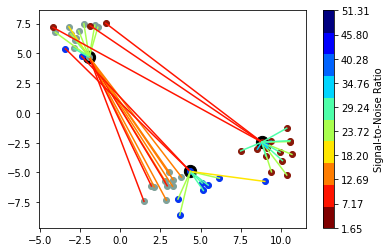

0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.270569


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291340
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.202291

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.261452
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.297775
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.252760

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.451187
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292846
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.172606

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1678, Accuracy: 3837/10000 (38%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.314877
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.275360
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.255386

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.297634
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.266961
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.279294

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303049
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

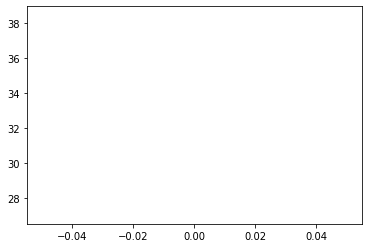

ROUND 0
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.294500


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291861
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.236886

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300588
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295891
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.281370

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.304487
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.295901
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.256563

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.288540
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285273
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.295875

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.1045, Accuracy: 4485/10000 (45%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299187
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.304229
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.291904

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298271
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.299957
Model

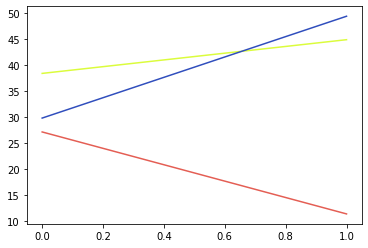

ROUND 1
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.241932


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.128779
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.853377

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.235394
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.204350
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.023184

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0487, Accuracy: 6375/10000 (64%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.296429
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285097
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.257377

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.292888
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.274443
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.257683

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

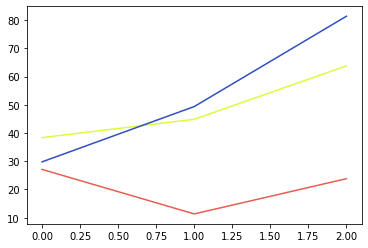

ROUND 2
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.991073


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.360236
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.152642

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.939265
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.345923
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.726831

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.027916
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.702837
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.051256

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.6650, Accuracy: 8156/10000 (82%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.265712
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.089352
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.928118

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.256145
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.945022
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.559605

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

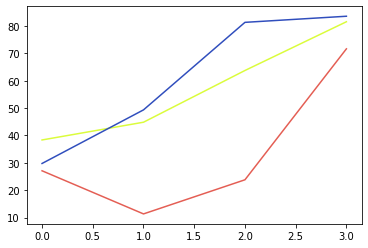

ROUND 3
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.822568


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.551681
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.241917

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.733109
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.499300
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.262650

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.772680
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.292612
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.088364

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7991, Accuracy: 8240/10000 (82%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.251543
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.051726
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.578738

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.239457
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.929344
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.482372

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

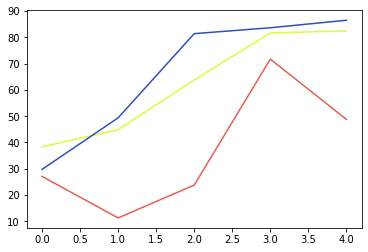

ROUND 4
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.319777


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.839794
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.695090

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.472373
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.998140
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.323792

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.448701
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.924603
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.790661

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.352694
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071548
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.102171

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.5783, Accuracy: 8811/10000 (88%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.174114
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.621928
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.291316

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.133349
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.673163
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.154976

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

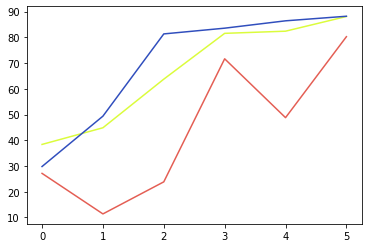

ROUND 5
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.279104


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.805836
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.680666

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.411844
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.133625
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.943987

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.325156
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.071674
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.596761

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.590081
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.012514
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.247714

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3060, Accuracy: 8954/10000 (90%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.139527
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.779142
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.505344

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.220656
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.936260
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.362880

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

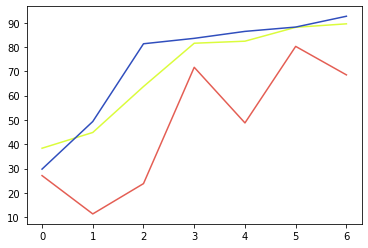

ROUND 6
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.188019


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.510233
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.539217

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.155878
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.926431
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.819033

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.463788
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.700233
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.775458

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.5163, Accuracy: 9220/10000 (92%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.111035
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.680947
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.391021

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.176145
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.296959
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.201154

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.132858
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

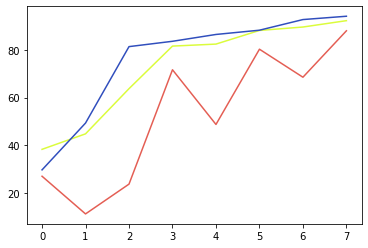

ROUND 7
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.325945


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.630208
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.927842

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.277477
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.578776
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.489369

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.202244
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.692021
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.178111

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.164347
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.628837
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.786597

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7539, Accuracy: 9333/10000 (93%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.075614
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.521931
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.005075

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.183597
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.121527
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038786

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

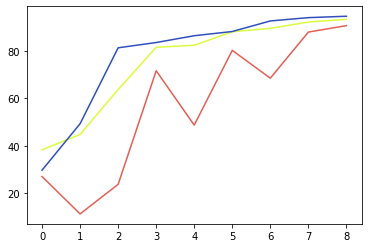

ROUND 8
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.881776


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.462830
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.761759

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.978134
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.677283
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.536966

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.248376
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.456752
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.856501

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.623105
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.387570

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.0726, Accuracy: 9431/10000 (94%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.037778
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.235400
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.831959

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.054354
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.117024
Model

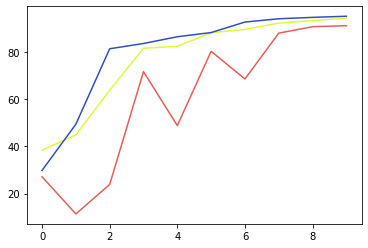

ROUND 9
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.131901


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.449607
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.859760

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.183422
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.443820
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.467465

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.940747
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.645901
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306838

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.8344, Accuracy: 9430/10000 (94%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.080757
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.180126
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.272152

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.124542
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.131340
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.658302

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

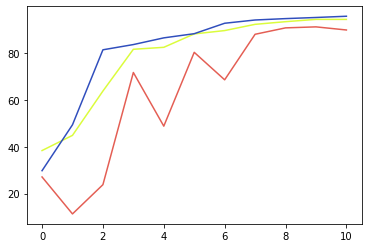

ROUND 10
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.673895


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.378237
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.275064

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.756960
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.306764
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.445914

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.947358
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.518378
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.356250

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.954995
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8126, Accuracy: 9495/10000 (95%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.027063
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.811323
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.467380

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.997655
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.865568
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.038100

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

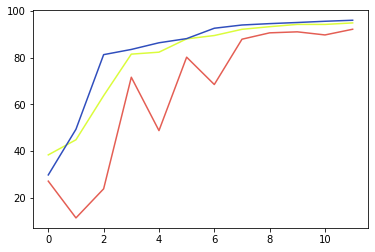

ROUND 11
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.997137


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.344995
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.276210

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.020791
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.526597
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.688643

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053183
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221908
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.634615

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.750586
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0892, Accuracy: 9475/10000 (95%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.097959
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.032428
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.119490

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.077596
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.089579
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.987381

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

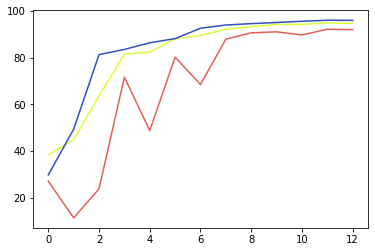

ROUND 12
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.935258


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.333338
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199283

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.919429
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.687478
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.188648

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.034414
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.485965
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.704406

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.879608
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.464965
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.829656

Power Allocated= 4.196180496999148
CSI= 0.871092526

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.6880, Accuracy: 9480/10000 (95%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.031893
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.259116
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.069737

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.085738
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.939074
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.234763

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

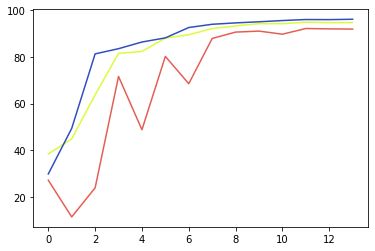

ROUND 13
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.918016


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.421571
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.594913

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633471
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260258
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.890056

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.744320
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294898
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.748089

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.659831
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.289957
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.830808

Power Allocated= 4.196180496999148
CSI= 0.871092526

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285764
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306998

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.6511, Accuracy: 9535/10000 (95%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.013959
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.734144
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.743524

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.990782
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.637893
Model

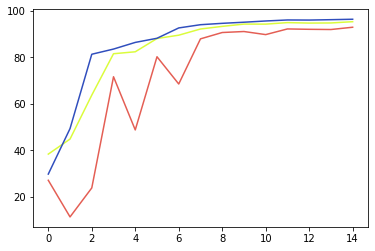

ROUND 14
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760277


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282388
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.012593

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.022638
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.366746
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.611370

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.893296
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.352389
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.476928

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.017637
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7748, Accuracy: 9532/10000 (95%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.960468
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.963658
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953316

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.100026
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.997149
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.675311

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

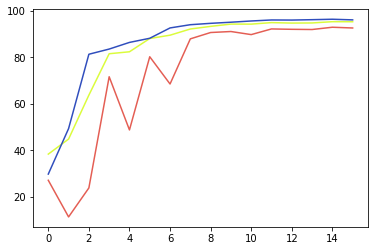

ROUND 15
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.029518


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.503487
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.517921

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.016296
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.562865
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.034655

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.5302, Accuracy: 9544/10000 (95%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.035490
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.825028
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.836704

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.032322
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.761513
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.009358

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

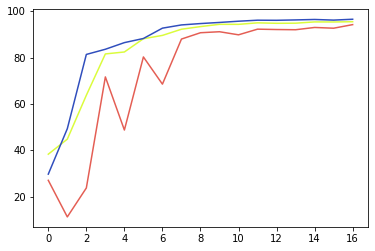

ROUND 16
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676888


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165741
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.353362

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.556636
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313608
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.263083

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509427
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.465843
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.398407

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.780931
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.408850
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.591990

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0481, Accuracy: 9555/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.964355
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.716462
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.977712

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.029804
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.507702
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.438902

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

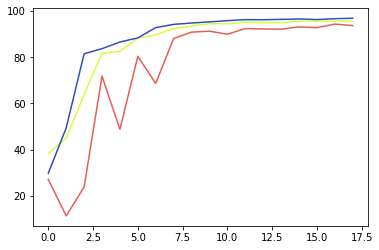

ROUND 17
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.053716


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323144
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.494882

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.848232
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.617204
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.328218

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.972222
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379921
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.592454

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.557146
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.474883

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 0.7193, Accuracy: 9587/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.093692
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.549355
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.957943

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR=

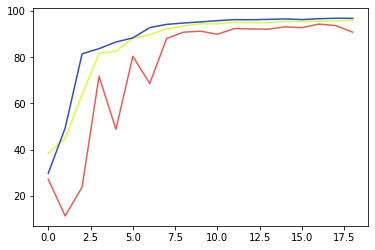

ROUND 18
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.039688


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192417
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.307187

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.439834
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.614902
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286108

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.2307, Accuracy: 9594/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.072304
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.907112
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.452268

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.081868
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.680965
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.422347

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

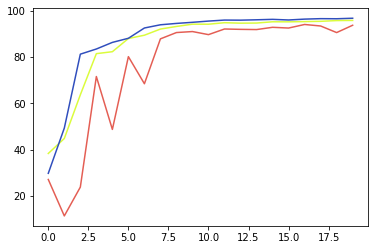

ROUND 19
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.733513


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167378
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.232439

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763681
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.720712
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.456028

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.731138
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.371861
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.725214

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1100, Accuracy: 9596/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.033152
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.483243
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.271154

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.930071
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345779
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.210810

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

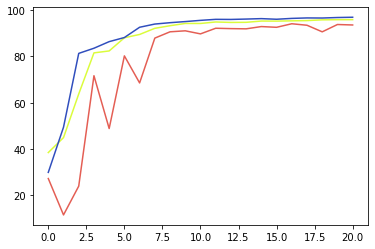

ROUND 20
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.930605


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.456277
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.649924

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632489
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.325294
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182186

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.894678
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.721357
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.037862

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.879700
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.9485, Accuracy: 9566/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.999872
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.821646
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.758765

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.999491
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.542091
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.447833

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

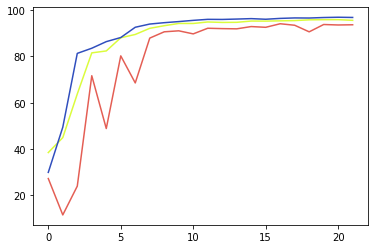

ROUND 21
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.800341


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155920
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.908896

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.590221
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173364
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.907052

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.602399
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278986
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.416289

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0003, Accuracy: 9588/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.954100
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.523676
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.770957

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.022050
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.779125
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.358456

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.103287
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

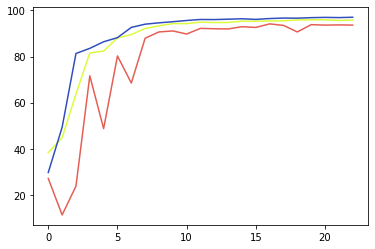

ROUND 22
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760318


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147600
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.441559

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.954556
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.545799
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.573353

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.819065
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379989
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.908070

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.920900
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.468642
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.795033

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3442, Accuracy: 9617/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.014519
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.543534
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.655762

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.033455
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.471761
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.939416

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

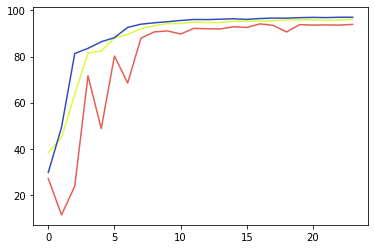

ROUND 23
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.672310


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078288
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.572328

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586374
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162793
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.401261

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.4763, Accuracy: 9632/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.983472
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.637654
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.708392

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.041655
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.402562
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.573312

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

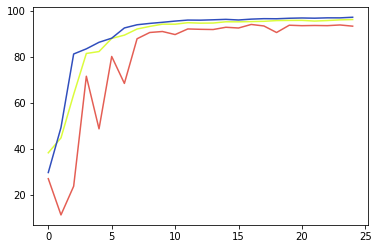

ROUND 24
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.596531


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.488224
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.711640

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615453
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085469
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.842005

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.789308
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165896
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.758945

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7680, Accuracy: 9633/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.954778
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.627341
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.502523

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.035939
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.652355
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.624109

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

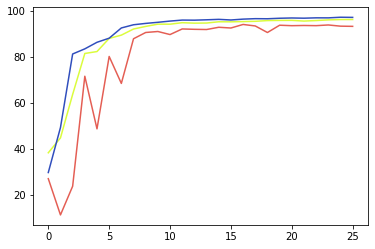

ROUND 25
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632174


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.463240
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.409324

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.578653
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126787
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372684

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.618101
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210519
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.610024

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.010456
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.4939, Accuracy: 9659/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.828591
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.344016
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.201719

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.804348
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.608272
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.992792

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

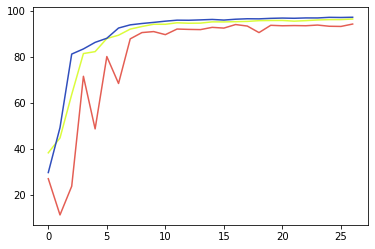

ROUND 26
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.021926


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.434280
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237293

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595923
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161747
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.493658

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.858510
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.202722
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.405828

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603522
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167627
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.445045

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.5806, Accuracy: 9651/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.993056
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.640441
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.555153

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.979467
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.638882
Model

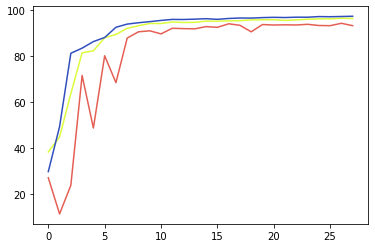

ROUND 27
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703551


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248478
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240873

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725478
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.420415
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.007335

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682203
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286507
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484172

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.189022
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156369
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.428076

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7764, Accuracy: 9630/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.004966
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.531306
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.336324

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.984470
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.636350
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.299731

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.980980
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

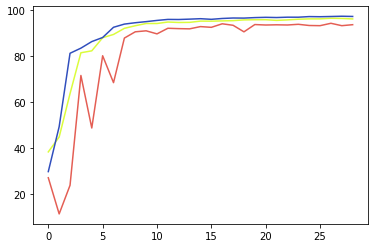

ROUND 28
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639062


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245572
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.301913

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.752779
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.341610
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484004

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.684405
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249428
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.365857

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.648097
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.311667
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.634820

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 4.6215, Accuracy: 9632/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.949849
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.382119
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.286713

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.122125
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.613458
Model

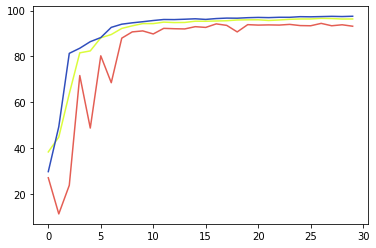

ROUND 29
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690003


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.231859
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.618616

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.554927
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.274996
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.178628

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.707439
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351274
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.248656

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.533870
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.903804

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.6814, Accuracy: 9666/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.950854
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.541530
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.661198

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.974598
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.356917
Model

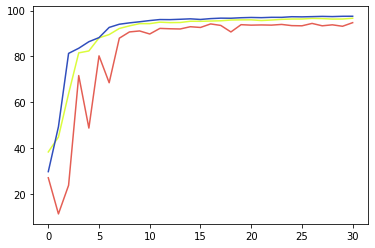

ROUND 30
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542650


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190498
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.521709

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.605521
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256816
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.550535

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.049510
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170238
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.481011

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725948
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167380
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.649300

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.7797, Accuracy: 9646/10000 (96%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.008124
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315419
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.794143

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Poor Channel, client not taken for averaging in this round

Power

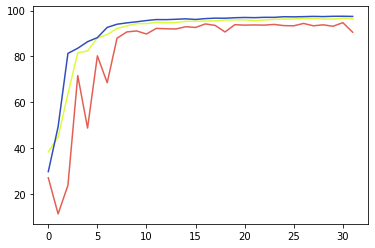

ROUND 31
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.611873


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180148
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.053965

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664916
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.262969
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.542925

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.517388
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351277
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.395270

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0567, Accuracy: 9669/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.980914
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.388496
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.852794

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.095443
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.606925
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.088540

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

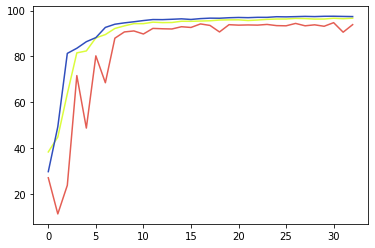

ROUND 32
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.458388


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115609
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.439463

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.518931
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.440729
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.481414

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.519723
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254826
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.783237

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478003
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.343292
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.704823

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.332777
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.971033

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 0.9823, Accuracy: 9688/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.854480
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.352494
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.388522

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.802126
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212964
Model

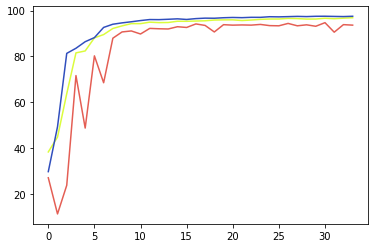

ROUND 33
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.740042


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113991
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.515397

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.767381
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345025
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193048

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.778018
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.357436
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.420048

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797275
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1361, Accuracy: 9662/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.988173
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.447691
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.765453

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.069340
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.506587
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.388970

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

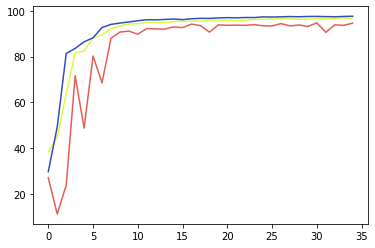

ROUND 34
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.673368


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219086
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.284822

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515308
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207894
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.358944

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.672119
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284561
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.533601

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.444909
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.610935

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 0.8764, Accuracy: 9669/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.978380
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.484625
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480769

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.109889
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.470764
Model

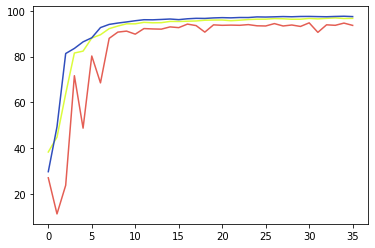

ROUND 35
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.685261


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100430
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.834687

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.606752
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309825
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.560233

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.594703
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133023
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.652190

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.654000
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.8467, Accuracy: 9665/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.948308
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.665981
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.072442

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.916948
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.359628
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.413239

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.034304
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

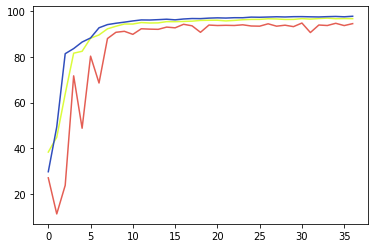

ROUND 36
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.511920


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256294
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.423836

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603630
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.548762
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.401240

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503119
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.287396
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.434484

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760561
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1986, Accuracy: 9674/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.004448
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.659207
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.273806

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.913997
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.357369
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.145913

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

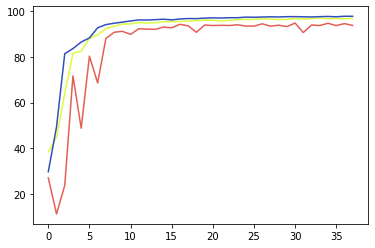

ROUND 37
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.379912


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085035
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126196

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.479906
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172456
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.293990

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498404
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197601
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404291

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.5747, Accuracy: 9702/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.779047
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.444603
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.622977

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.797339
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.479304
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.311307

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

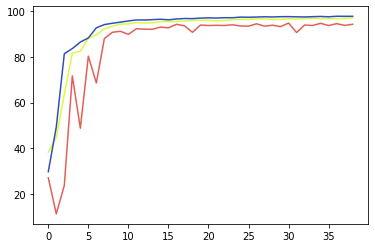

ROUND 38
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400043


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183084
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097308

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.670140
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.376723
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.398319

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.474173
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258485
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.597985

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.398088
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0310, Accuracy: 9710/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.801990
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392657
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.690925

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.683725
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.325744
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.878596

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

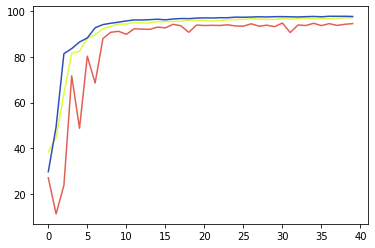

ROUND 39
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513444


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123707
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094632

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004997
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.428930
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.377510

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.764751
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335750
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.704211

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.680074
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5012, Accuracy: 9699/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.978024
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.868386
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.836931

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.990939
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317374
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.811662

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

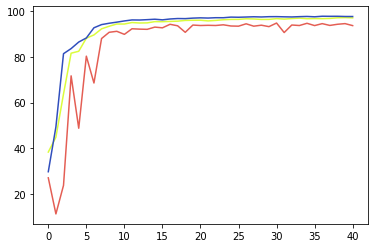

ROUND 40
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.863478


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139121
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209688

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.853920
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179613
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.233542

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897973
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215245
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.165364

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2358, Accuracy: 9684/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.035177
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414033
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.977362

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.123530
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.481897
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.984548

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

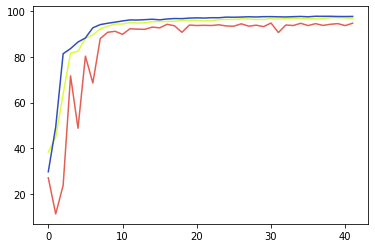

ROUND 41
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.672039


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140041
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080882

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.941827
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207511
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.495758

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.835411
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268249
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.302964

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586221
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.5794, Accuracy: 9675/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.010920
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.528674
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.101661

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.957325
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.423224
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.128721

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

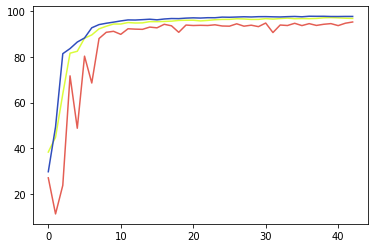

ROUND 42
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.573798


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134862
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145649

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.804139
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192833
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.361723

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Model client20 Train Epoc

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.9808, Accuracy: 9676/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.056017
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.629708
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353703

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.952933
Model 

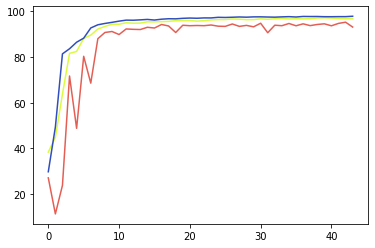

ROUND 43
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461798


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227547
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.429989

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.575533
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.308463
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.700526

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345393
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201911
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.632385

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132667
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202353

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.8384, Accuracy: 9698/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.785422
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.727529
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.188191

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.869956
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.273748
Model

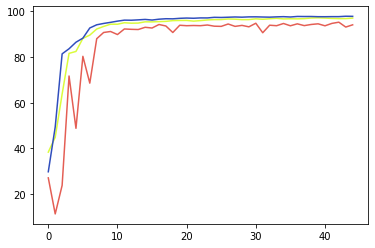

ROUND 44
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448904


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244631
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224585

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340326
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078642
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.825607

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375608
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103159
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.156741

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.254310
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.467055

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.6562, Accuracy: 9709/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.803801
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.674421
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.027091

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.740569
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379719
Model

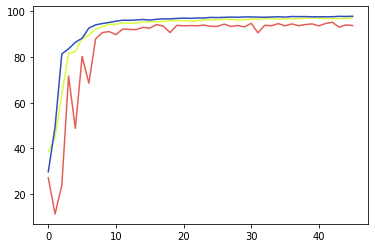

ROUND 45
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.499408


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119882
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.260866

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459015
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038793
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.415106

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.785585
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.274817
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.757491

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.263463
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2855, Accuracy: 9682/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.990811
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.514375
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.372667

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.002398
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.335373
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.773570

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

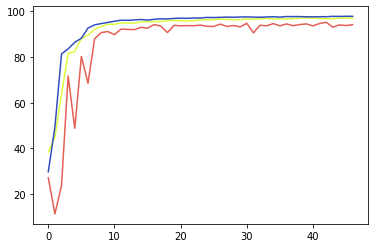

ROUND 46
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441300


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105459
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143581

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527823
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177835
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211770

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621590
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176315
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.507614

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.5815, Accuracy: 9694/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.973145
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.684434
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.763966

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Poor Channel, client not taken for averaging in this round

Power

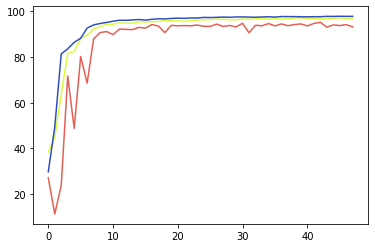

ROUND 47
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498454


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116342
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236678

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.970585
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.523108
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.598126

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507146
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243558
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255407

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.267759
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.364876

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.1670, Accuracy: 9700/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.907665
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.564697
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.406233

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.925355
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265392
Model

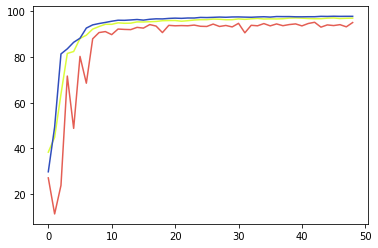

ROUND 48
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664625


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034626
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.248436

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.844983
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277782
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.658811

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.606230
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062013
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.717890

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.683925
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209762
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.736554

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1994, Accuracy: 9691/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.979039
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.795157
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.953785

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.092510
Model 

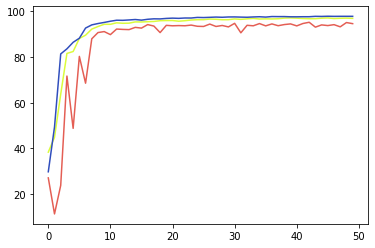

ROUND 49
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.674434


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110477
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.375967

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.895827
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.202056
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326114

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.880401
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.318525
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.999071

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224839
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.620972

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.0712, Accuracy: 9674/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.120162
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.541449
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.615336

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.046396
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351520
Model

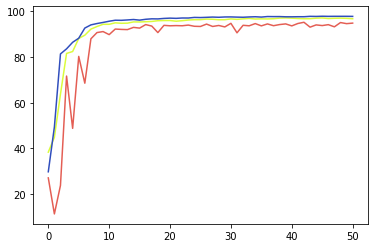

ROUND 50
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.568263


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152258
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092236

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.047039
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.556178
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.470241

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.709716
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155668
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.355969

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439996
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188056
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.436750

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.5279, Accuracy: 9705/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.903475
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.550335
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.890689

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.948538
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450372
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.626932

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

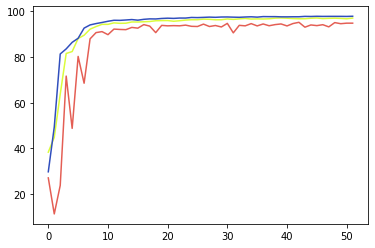

ROUND 51
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463468


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180759
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174998

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.305725
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185530
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189848

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503339
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247071
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.715215

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337819
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190413
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.337474

Power Allocated= 4.196180496999148
CSI= 0.871092526

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.3688, Accuracy: 9696/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.841350
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.835367
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.193126

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Poor Channel, client not taken for averaging in this round

Power

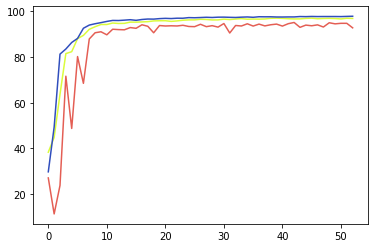

ROUND 52
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.391169


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237944
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.342865

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516100
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334608
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041742

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542037
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.419466
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.916048

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.776635
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.9145, Accuracy: 9698/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.767439
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400704
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.617881

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.820607
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.499184
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.002241

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

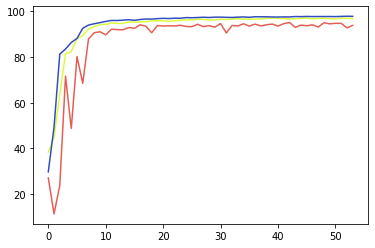

ROUND 53
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359543


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.217265
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.532984

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405245
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201824
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209716

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342939
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049020
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239448

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415220
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2570, Accuracy: 9720/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.798973
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.593574
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.979691

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.968201
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151198
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.829310

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

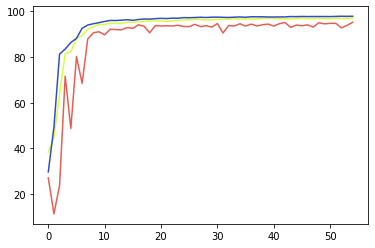

ROUND 54
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483848


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.293645
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.500279

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.578710
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045080
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.783274

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.654447
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.354803
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224808

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527298
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074875
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.355911

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.5844, Accuracy: 9710/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.972423
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.716704
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.339023

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.909583
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.758897
Model

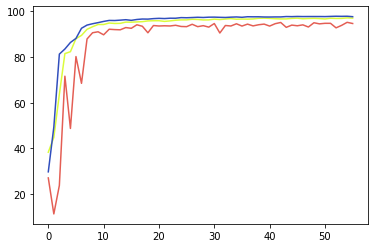

ROUND 55
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.695170


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304788
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189326

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.642549
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132903
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120936

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.612543
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.325016
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.239149

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0085, Accuracy: 9715/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.001247
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.791022
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.381729

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.079228
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.456908
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.231465

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.013474
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

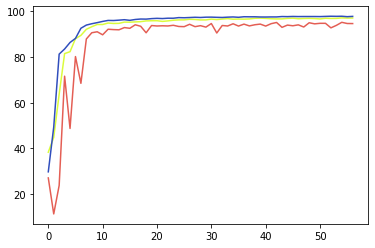

ROUND 56
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.606280


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070585
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189607

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.526239
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345957
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349737

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.395797
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121244
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.783462

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649218
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091461
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177685

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.4106, Accuracy: 9703/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.940966
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.378517
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.734627

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.864510
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.548938
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.519339

Power Allocated= 6.836233321466889
CSI= 0.400704

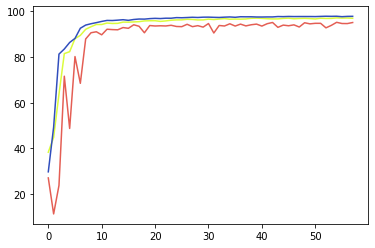

ROUND 57
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507531


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087818
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180379

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.548556
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.330599
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073392

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.625732
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151101
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.361006

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725009
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.201683
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.195428

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2544, Accuracy: 9710/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.922500
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.901711
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.961860

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.947895
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.508811
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.625924

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

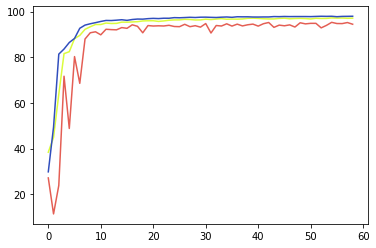

ROUND 58
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.665728


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.302946
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215135

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.632618
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127160
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.431188

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197378
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.430190

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.0206, Accuracy: 9703/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.968294
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.424275
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.212672

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.056152
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.583901
Model

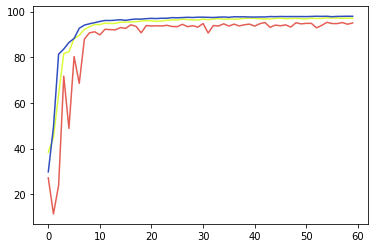

ROUND 59
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509222


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.238105
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.229367

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.943400
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175851
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.774984

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.240479
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.569667
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.445140

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.4534, Accuracy: 9693/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.048266
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.812859
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.558663

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.031581
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.558813
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.747501

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

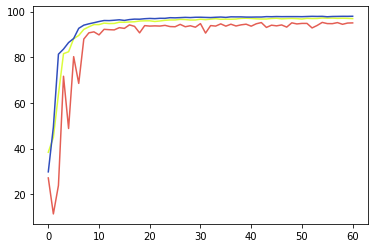

ROUND 60
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353636


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237141
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.700216

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.426962
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184598
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.513997

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0339, Accuracy: 9702/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.819336
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.186794
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.639407

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.845934
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.361909
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.912786

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

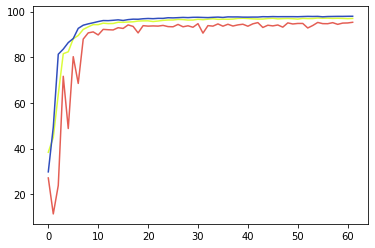

ROUND 61
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384360


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150611
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349384

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.319116
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304219
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.292512

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725187
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.516781
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.799639

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.736082
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1416, Accuracy: 9720/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.835128
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.512257
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566615

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.793864
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.535381
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.610709

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

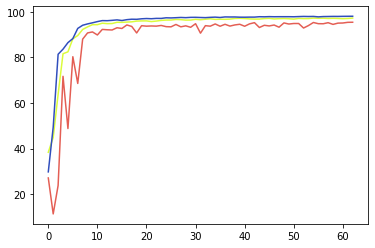

ROUND 62
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411238


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.388352
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141450

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376493
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.271454
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.085232

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478955
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132324
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.921677

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.9525, Accuracy: 9698/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.934893
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.468592
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.591270

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.881656
Model 

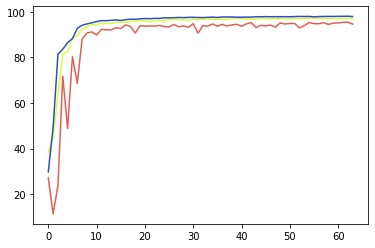

ROUND 63
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483253


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059978
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252665

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.537299
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030861
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153362

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.407148
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160189
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.510706

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.359877
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283523

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.1241, Accuracy: 9728/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.974726
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379414
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.131260

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.829543
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266143
Model

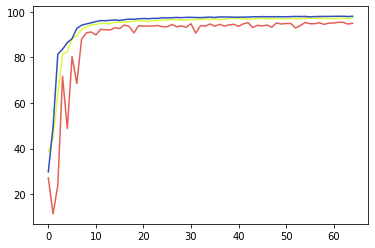

ROUND 64
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.561152


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104083
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.202878

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.748751
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156437
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357646

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.2873, Accuracy: 9698/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.961192
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345107
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.975672

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.957808
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.435823
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.069804

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

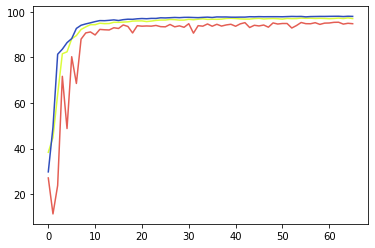

ROUND 65
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394630


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044395
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285348

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410245
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210868
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.105272

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.611647
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214288
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.384499

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.546268
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130616
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.587296

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.3220, Accuracy: 9718/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.927622
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.355635
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.088840

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.809410
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.354959
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.126835

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

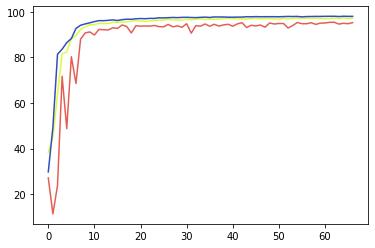

ROUND 66
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.828204


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227058
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390205

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.559565
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050298
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082808

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.995505
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351169
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216979

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.6750, Accuracy: 9706/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.926503
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237555
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155781

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.002395
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.786446
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.644623

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

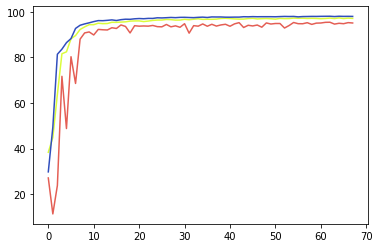

ROUND 67
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.569968


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051134
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041999

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532884
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082366
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098923

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.738276
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317048
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335532

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7944, Accuracy: 9716/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.924709
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.778386
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.496643

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.947126
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242401
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.250158

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

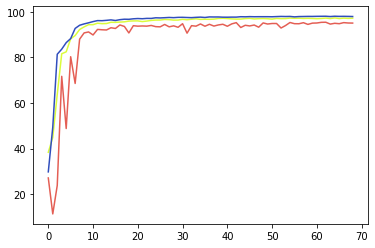

ROUND 68
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.608632


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083786
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175560

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.566107
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098696
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226118

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.3006, Accuracy: 9710/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.953572
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.457238
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.001638

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.917605
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.594675
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.993684

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

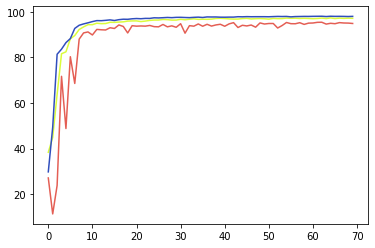

ROUND 69
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386437


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038797
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.262377

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402432
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049868
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.357458

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522323
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178242
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306488

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.535046
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8539, Accuracy: 9690/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.800258
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.521422
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.840680

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.721197
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.425884
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.479013

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

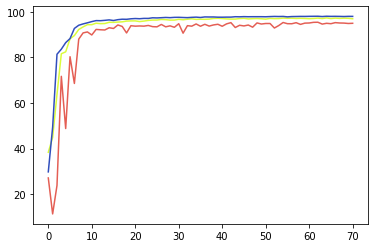

ROUND 70
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.648404


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.312660
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.559547

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417751
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183139
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.318445

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366034
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239852
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.328427

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437483
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154566
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.304947

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.3466, Accuracy: 9715/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.838235
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.947239
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.809146

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.740608
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155578
Model

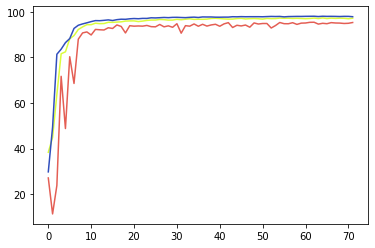

ROUND 71
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.643097


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188852
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347975

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377249
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065825
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.277888

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405966
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172022
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316146

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0820, Accuracy: 9692/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.788555
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.312939
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.830214

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.931518
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.419391
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.387110

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

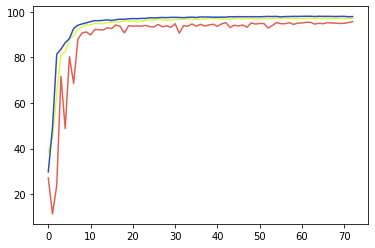

ROUND 72
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.430808


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169484
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.041821

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.295453
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155615
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.414157

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509797
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209947
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.383925

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.8402, Accuracy: 9731/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.704422
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551548
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.947081

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.647313
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.446477
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.238672

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

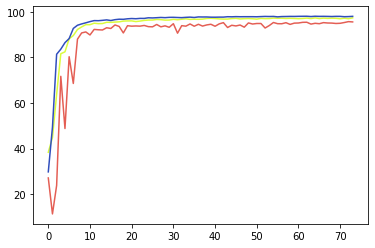

ROUND 73
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358903


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075508
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175001

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.779753
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104416
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.251602

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7135, Accuracy: 9722/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.893327
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062039
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.585352

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.119637
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.363144
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.630604

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

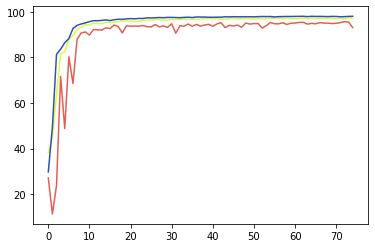

ROUND 74
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.748664


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235289
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237952

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.109048
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228469
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.546562

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.640330
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233471
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.145923

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7961, Accuracy: 9698/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.108028
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.320549
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.898950

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.979863
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.340202
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.655486

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

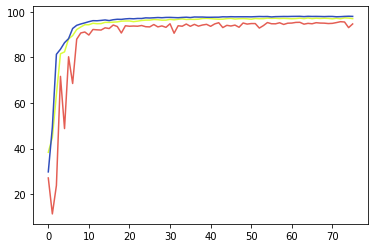

ROUND 75
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.878770


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109963
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204040

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.822390
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120517
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.253467

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.958711
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.337702
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.921514

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.479908
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.0360, Accuracy: 9709/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.120723
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441564
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.435938

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.079299
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221845
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.366641

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

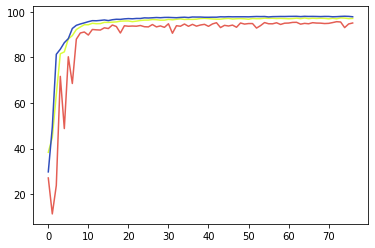

ROUND 76
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432297


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180105
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181235

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.592320
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113678
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252861

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487563
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198802
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181223

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.4845, Accuracy: 9707/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.973688
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.404560
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.219686

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.949226
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235346
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 4.292341

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

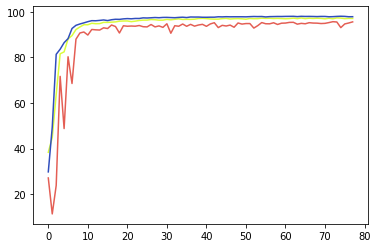

ROUND 77
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459883


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282995
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.293738

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.747825
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.275606
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.746530

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.558948
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180925
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157770

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436813
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.9375, Accuracy: 9703/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.915832
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.613261
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.165714

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.977955
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.490560
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.386133

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

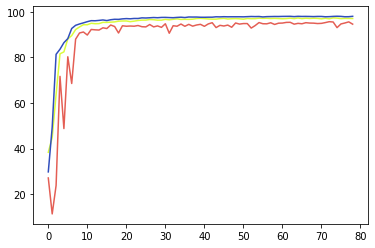

ROUND 78
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.452027


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078491
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.564723

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.397982
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079963
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.346757

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.317402
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037655
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169915

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8891, Accuracy: 9716/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.920330
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.448059
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.923157

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.874375
Model 

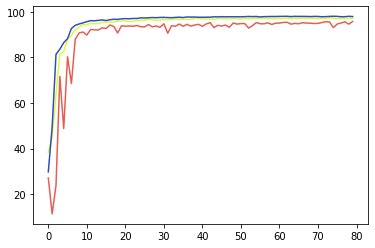

ROUND 79
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.381989


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118797
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.443859

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392036
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249062
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252143

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307033
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216494
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.236743

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.573487
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291559
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.169330

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.9983, Accuracy: 9723/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.755970
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.442173
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.138811

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.733742
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211789
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566771

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

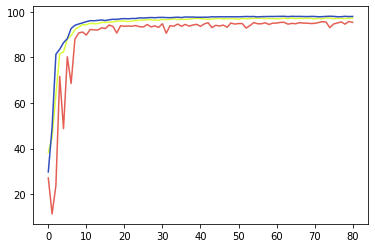

ROUND 80
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346226


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095330
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114298

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.735677
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248848
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.359757

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.493869
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.396128
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205831

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515763
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.208903
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.927092

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222447
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.689943

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.3808, Accuracy: 9738/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.832613
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179099
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.543338

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.653621
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405685
Model

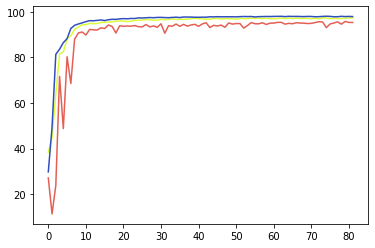

ROUND 81
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.433519


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032181
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.776954

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332749
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120088
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.570229

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.320726
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121826
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.462200

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1677, Accuracy: 9720/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.715122
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.357492
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371611

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.733073
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.256268
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.603516

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.813120
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

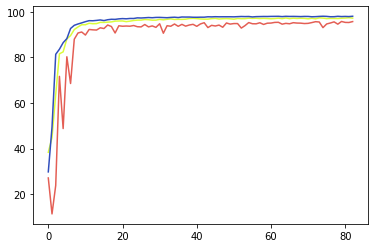

ROUND 82
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.331202


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114560
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201011

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.267741
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.425949
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182993

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.264209
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323381
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190424

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5253, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.802487
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.346819
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.436265

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.755813
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551912
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.645996

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

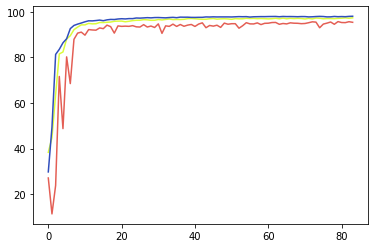

ROUND 83
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.528898


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074601
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124385

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481824
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151149
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.448468

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3385, Accuracy: 9743/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.872289
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.524379
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.940846

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.811410
Model 

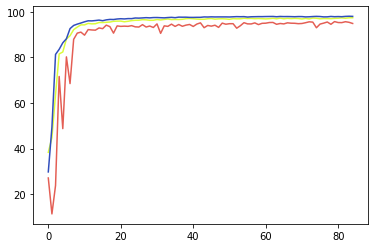

ROUND 84
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.572592


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.283381
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374315

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.290941
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043617
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055712

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431748
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.510243
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.421188

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.661845
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205868
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238652

Power Allocated= 4.196180496999148
CSI= 0.871092526

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.7811, Accuracy: 9757/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.927913
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.214253
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.734674

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.778322
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149162
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.699396

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

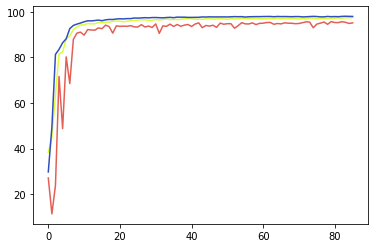

ROUND 85
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.560142


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294637
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218690

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.683813
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044063
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050023

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.350864
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164698
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.603232

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530761
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8892, Accuracy: 9733/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.907429
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.418913
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.740850

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.024799
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.707628
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.871901

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

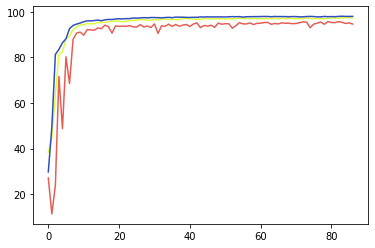

ROUND 86
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456956


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100494
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.209146

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504674
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058902
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.114905

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609852
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067567
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249424

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1292, Accuracy: 9721/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.894988
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.521725
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.750458

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.905993
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.408774
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.923650

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

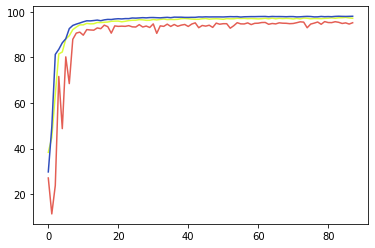

ROUND 87
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469581


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064928
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.401858

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405442
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118945
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.213562

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428504
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.291515
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.485978

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428501
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183678
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.438332

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257620
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.320415

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.9820, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.841489
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.809394
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.723222

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.952510
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.781007
Model

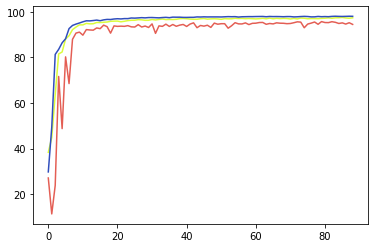

ROUND 88
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468978


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183749
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059989

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.334784
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347277
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.656826

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406574
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204925
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.270316

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.6897, Accuracy: 9736/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.743951
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.250786
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.827878

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.784917
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.744724
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.031065

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

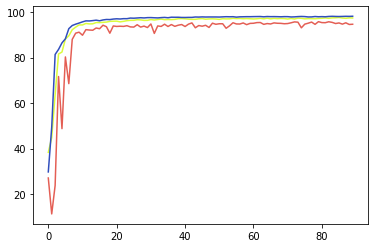

ROUND 89
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.302972


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061542
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.295836

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403098
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033102
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.535570

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649030
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135363
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.496575

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2071, Accuracy: 9731/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.785820
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.152649
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.623267

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.812595
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.457457
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.821508

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

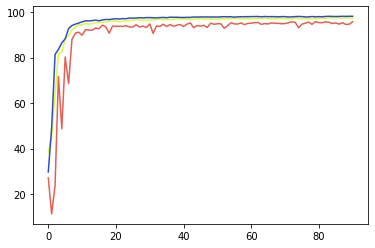

ROUND 90
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467988


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.522663
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.304170

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417930
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.110772
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.291785

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.404862
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177778
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.241896

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101815
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323998

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.8528, Accuracy: 9738/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.898081
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.489186
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.932389

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.000374
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.392262
Model

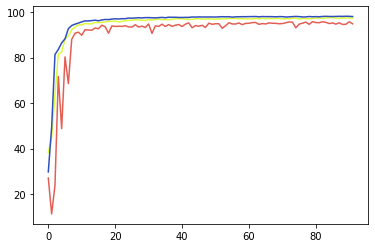

ROUND 91
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.423717


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160813
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.934980

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417450
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117910
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.111353

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316076
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.225187
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484199

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.930950
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264303
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.300187

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.2342, Accuracy: 9721/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.824896
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.255097
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.493420

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.887196
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.273832
Model

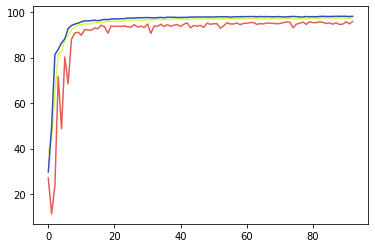

ROUND 92
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412595


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038175
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.661023

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431245
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224951
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097985

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335752
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282986
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.626346

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.540150
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1733, Accuracy: 9738/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.834946
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204819
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.874021

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.863549
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.567964
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.775521

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

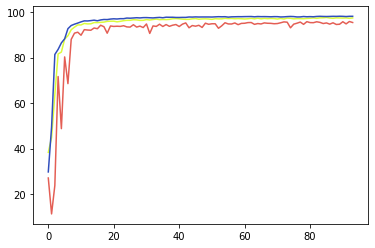

ROUND 93
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.301203


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.374862
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.241283

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.319294
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132313
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.652598

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504591
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122465
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.447171

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.491760
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.7711, Accuracy: 9727/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.830990
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.316719
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.144078

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.998708
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.267719
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.912998

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

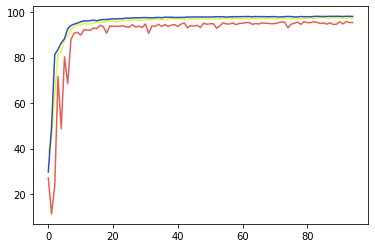

ROUND 94
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.374857


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188689
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204336

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.323618
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013065
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.385866

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530314
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138316
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.558304

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294139
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099558
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.500852

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.0596, Accuracy: 9745/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.703973
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.022502
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.776533

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.685097
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.331076
Model

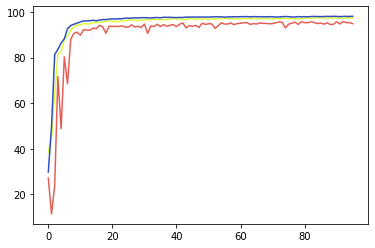

ROUND 95
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240330


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172963
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330293

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.989188
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108888
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.582387

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261840
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128398
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.488367

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298355
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1265, Accuracy: 9748/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.685979
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351931
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.837582

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Poor Channel, client not taken for averaging in this round

Power

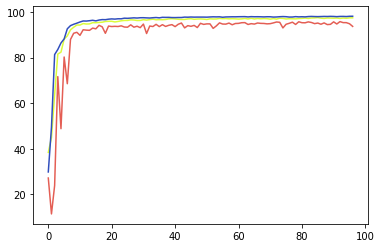

ROUND 96
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257571


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203810
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.235257

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408151
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228201
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218308

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Model client20 Train Epoc

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.8244, Accuracy: 9730/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.792453
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.453885
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.010883

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.746057
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.367891
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480508

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

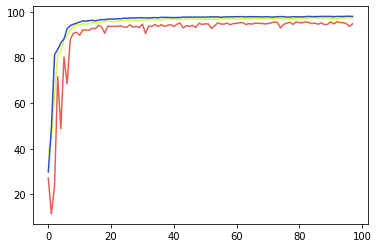

ROUND 97
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360201


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281630
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086039

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392433
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091739
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224848

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367263
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144817
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.321998

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.8530, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.774024
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.394837
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.357325

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.810704
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.391906
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.520260

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

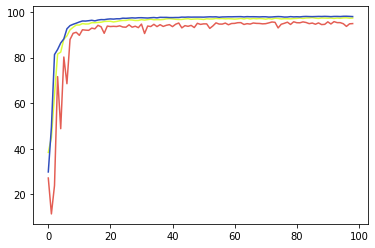

ROUND 98
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.291753


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040491
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.679566

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.257010
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055538
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201270

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.539705
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111638
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.126599

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8404, Accuracy: 9735/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.669449
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258210
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.742291

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.868461
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.479401
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.064545

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

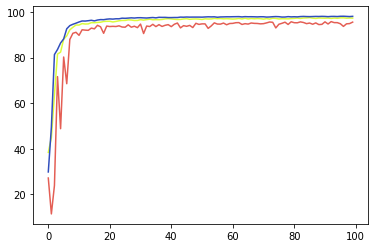

ROUND 99
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.182825


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178279
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.367250

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467855
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156173
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.392619

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.168276
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053942
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282170

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2835, Accuracy: 9764/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.432817
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.500052
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.890170

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.506644
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197277
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.381264

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

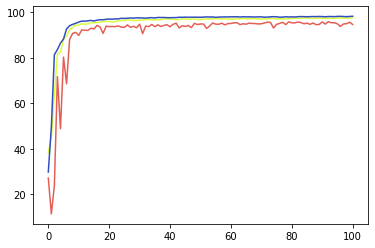

ROUND 100
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.239116


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049517
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221222

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444847
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103687
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117680

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.401436
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147007
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.489379

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090144
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.124815

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.0446, Accuracy: 9754/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.658296
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.506779
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.815026

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.728302
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.267371
Model

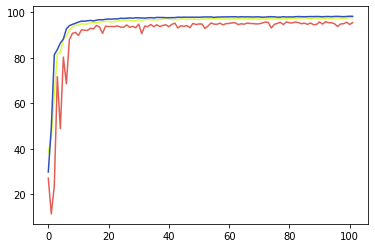

ROUND 101
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.397301


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043232
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180510

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.725396
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205064
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.753658

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388629
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086883
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.166316

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.304683
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108048
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.210041

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173091
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.263573

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.5510, Accuracy: 9749/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.781938
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307723
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.560388

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.908718
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334107
Model

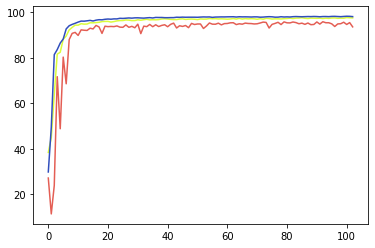

ROUND 102
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.330509


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086133
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.173688

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.580012
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077255
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.554033

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.902217
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.377516
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.327214

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8232, Accuracy: 9745/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.803575
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.483068
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.572249

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.846524
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.269587
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.735549

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

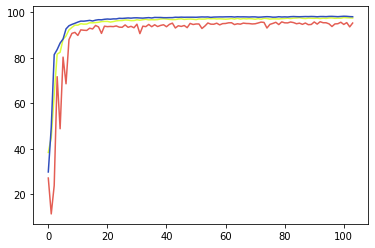

ROUND 103
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610443


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059678
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.003891

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.658072
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038184
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.586232

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.698928
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139831
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112064

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.604859
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1144, Accuracy: 9747/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.922359
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.907859
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.828153

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.884674
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.416478
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.957856

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

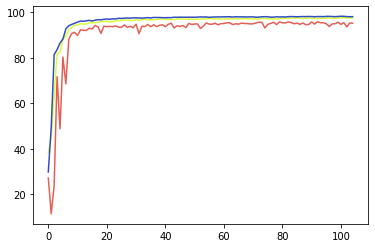

ROUND 104
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466897


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087823
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004779

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.729071
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109011
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.426291

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.685881
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164814
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174798

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2601, Accuracy: 9737/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.872767
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.603622
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.740402

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.881565
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174047
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.795240

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

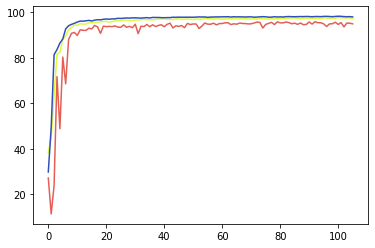

ROUND 105
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462409


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115547
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.592547

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703836
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183807
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.166051

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.966488
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240098
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.484725

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2540, Accuracy: 9742/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.797130
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.325907
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.650619

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.834610
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317287
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.990638

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

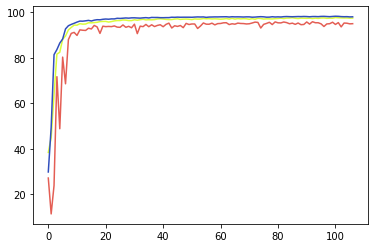

ROUND 106
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.347525


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.009641
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.312991

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.292536
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.007719
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.362739

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.253284
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126712
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132632

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.4689, Accuracy: 9733/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.807581
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.853355
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.647029

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.829175
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253699
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.476299

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

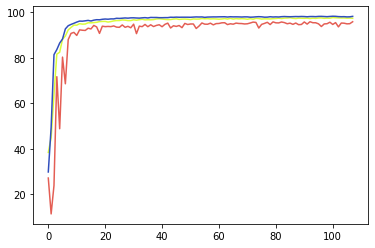

ROUND 107
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515493


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190929
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214823

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.289445
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017136
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.565171

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.684758
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216064
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015856

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.231751
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.5957, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.737417
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307142
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.783812

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.978593
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.337368
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.459231

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.746381
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

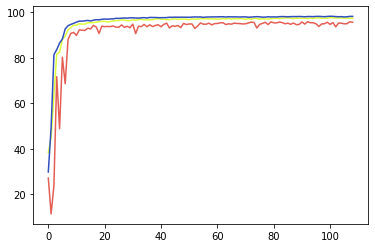

ROUND 108
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427601


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.401309
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.385097

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.273149
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.217123
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.568601

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.438483
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.184726
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.528226

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0257, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.691955
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.336283
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.580205

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.749890
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.432564
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.298019

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

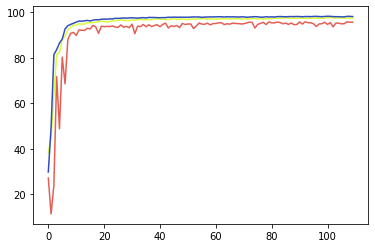

ROUND 109
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.249369


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078752
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174102

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448917
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175215
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.187702

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.387571
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.239933
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053258

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0687, Accuracy: 9734/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.669990
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.375314
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.873476

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.839498
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.255587
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.285721

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

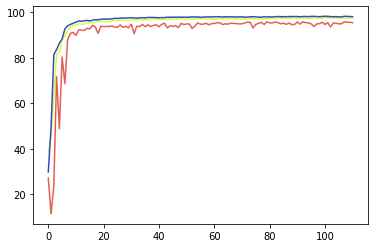

ROUND 110
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.347459


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025780
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247041

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.514171
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092078
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.467085

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402435
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106882
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042765

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.8628, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.723889
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.374616
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.900723

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.745259
Model 

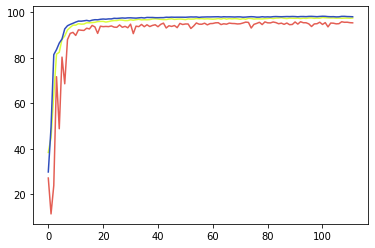

ROUND 111
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394724


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080020
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207017

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.520980
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282202
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.561975

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.374238
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059881
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.483835

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.387216
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131764
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286897

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.3514, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.815910
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.484603
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.722000

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.896630
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.749615
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.685745

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

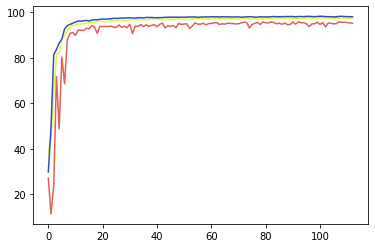

ROUND 112
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.334259


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223580
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153336

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.657522
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174956
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107046

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.553947
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272444
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.584502

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0298, Accuracy: 9726/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.822980
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.365369
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.781887

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.907568
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.818457
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.151944

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

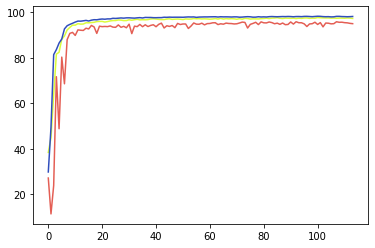

ROUND 113
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.295747


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040889
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.101859

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507451
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109566
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208282

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269106
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294618
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230429

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2724, Accuracy: 9733/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.768224
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.888792
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.184523

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.670296
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.407178
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.761550

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

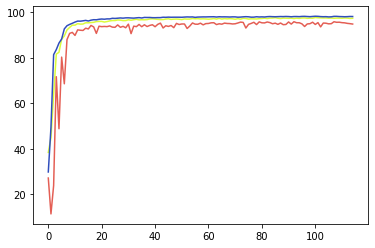

ROUND 114
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.541721


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.148589
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.523929

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712991
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303111
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.271276

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394915
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073389
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480868

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.074184
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.3036, Accuracy: 9731/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.989676
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.284007
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.713541

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.025006
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.606872
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.238088

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

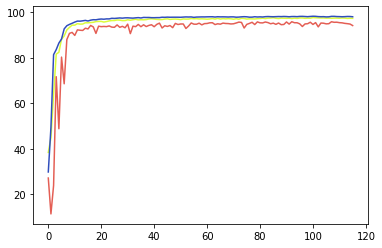

ROUND 115
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.533964


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088874
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052958

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.607999
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050618
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389829

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662293
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248740
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.337859

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.5139, Accuracy: 9733/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.927649
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.569390
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.383566

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.910978
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.472972
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.212086

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

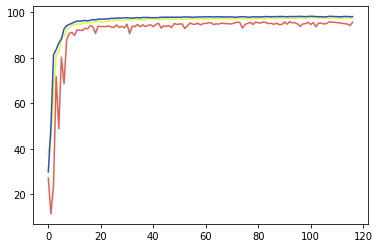

ROUND 116
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662133


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226435
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.492550

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411965
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151586
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206429

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.630627
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123511
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.945002

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226389
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100789

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.1855, Accuracy: 9741/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.857586
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176261
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.503359

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.934115
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.715526
Model

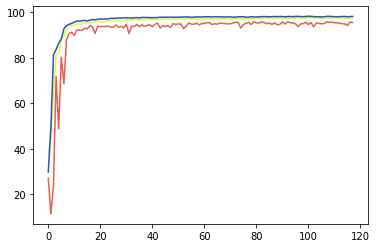

ROUND 117
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.232544


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119321
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.463068

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353631
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043760
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.718298

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.224409
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034844
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.081614

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5099, Accuracy: 9735/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.812011
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135017
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.641030

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.769619
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.560761
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.085004

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

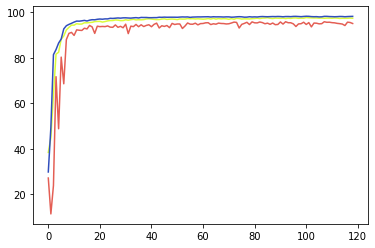

ROUND 118
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353271


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.093986
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.013851

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.721085
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112010
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.473103

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390041
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121935
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045203

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240085
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8598, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.815347
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.694289
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.382613

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.925070
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.499262
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.929343

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

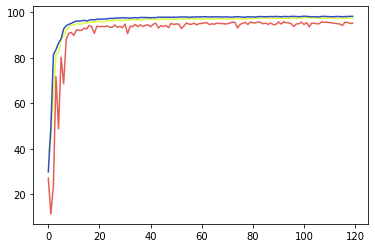

ROUND 119
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.814112


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057546
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.147411

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.482897
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160408
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.106472

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444437
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105003
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.489052

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623291
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044601
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.207245

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.3885, Accuracy: 9725/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.969989
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.322085
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.279965

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.073508
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.361352
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.532036

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.883543
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

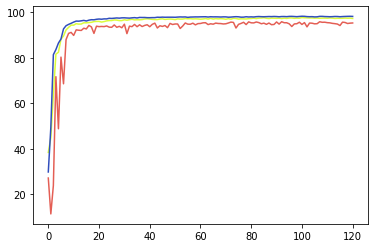

ROUND 120
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.315935


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075849
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326123

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327676
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049539
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.078818

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.7257, Accuracy: 9741/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.674073
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.509559
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.898521

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.029407
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138672
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389210

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.817206
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

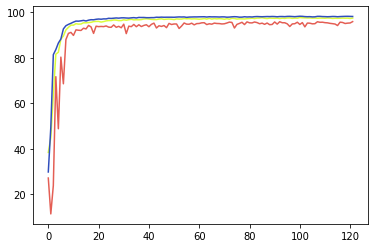

ROUND 121
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424116


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189797
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100653

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.152351
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044811
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.314630

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352889
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139932
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117000

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089384
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174842

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.5470, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.522007
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.381426
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.639627

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.578337
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209399
Model

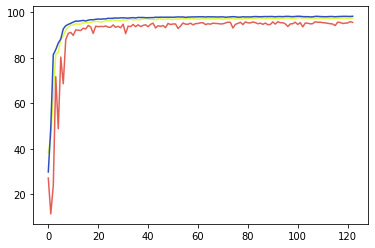

ROUND 122
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.282903


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085682
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098443

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.381239
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123003
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070225

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.198158
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027507
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.284500

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.9984, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.702398
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.722607
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.826603

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.724567
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.326862
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.124874

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

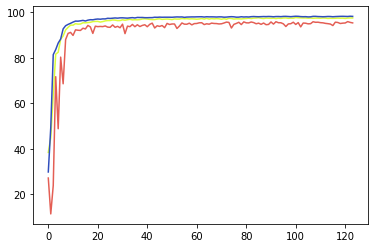

ROUND 123
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.255916


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095541
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216289

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.284667
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096273
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.247295

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346440
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085438
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.840442

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.504780
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8779, Accuracy: 9754/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.720237
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.897406
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.587916

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.697357
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.497908
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.697555

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

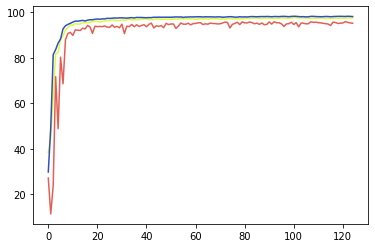

ROUND 124
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.401356


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104941
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109588

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507666
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.063366
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.498069

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.328192
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037123
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.120373

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340602
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146931
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240848

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.2970, Accuracy: 9738/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.739667
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.605058
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.521366

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.779110
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.332686
Model

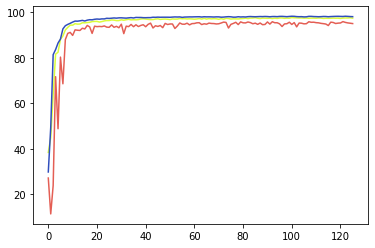

ROUND 125
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325219


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025838
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216200

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384627
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042501
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023548

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327245
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072033
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065852

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252483
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2986, Accuracy: 9779/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.714535
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.577178
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.792903

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.842461
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.348795
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.328166

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

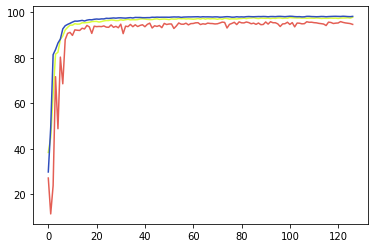

ROUND 126
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.381063


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111672
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.261139

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.400768
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155325
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075011

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399492
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047685
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088267

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.7627, Accuracy: 9758/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.709301
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414364
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.796634

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.865972
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.412318
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.107843

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

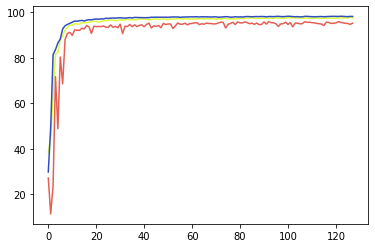

ROUND 127
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.374477


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060759
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.002457

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444929
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137113
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135864

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375721
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146245
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.220879

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3939, Accuracy: 9747/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.839880
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.406321
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.188001

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.873905
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.233549
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.837672

Power Allocated= 6.836233321466889
CSI= 0.400704

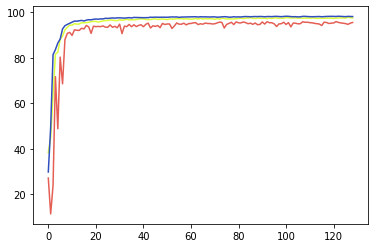

ROUND 128
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.449797


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129652
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.178593

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.495594
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145639
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.030091

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5306, Accuracy: 9758/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.862934
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242316
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.008713

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.903828
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.448534
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290300

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

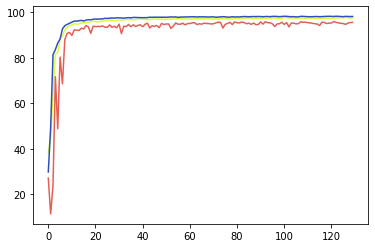

ROUND 129
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393239


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149073
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.334936

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.344010
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096429
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.421359

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712618
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075552
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.569454

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086458
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049585

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.2801, Accuracy: 9750/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.774356
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.316517
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.576892

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.938593
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.373969
Model

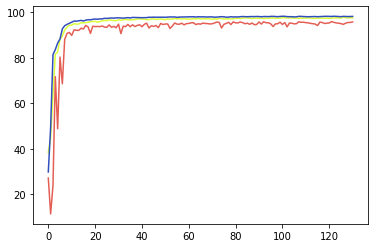

ROUND 130
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447881


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193679
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176188

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.314406
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192881
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.476330

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337227
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030781
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175950

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2827, Accuracy: 9756/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.764016
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096320
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.047079

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.802871
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.336456
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.072070

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

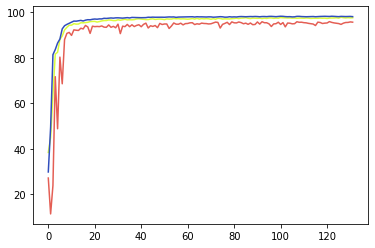

ROUND 131
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484388


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.005634
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.343579

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.594290
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145832
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.129628

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714431
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128461
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.166051

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.0241, Accuracy: 9744/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.904062
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180748
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.659940

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.010148
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.587126
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.379849

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

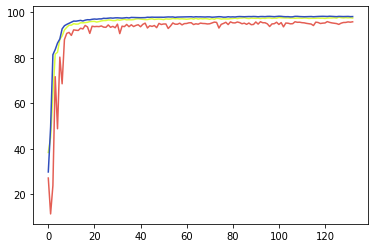

ROUND 132
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.324288


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116577
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084833

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527975
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084209
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155426

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.622710
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031431
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.604667

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1855, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.894575
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.496061
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.863993

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Poor Channel, client not taken for averaging in this round

Power

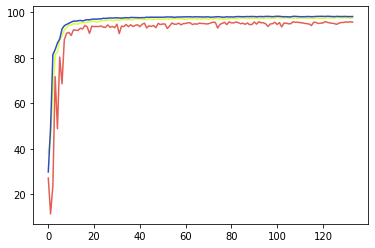

ROUND 133
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497382


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.156413
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.134981

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567350
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055952
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032883

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.731575
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101762
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.253047

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.572245
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246948
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.268493

Power Allocated= 4.196180496999148
CSI= 0.871092526

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037691
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.304875

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.8127, Accuracy: 9748/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.821624
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.991391
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.302116

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.992190
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157244
Model

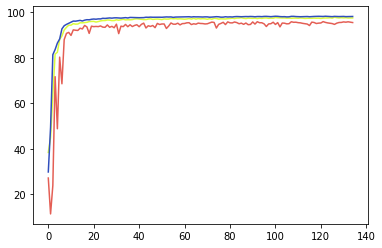

ROUND 134
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.329921


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035693
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.028483

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.372251
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078452
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243385

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.394041
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069941
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310211

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.420632
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.9035, Accuracy: 9748/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.854393
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.059106
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.447051

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.716578
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303909
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.111597

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

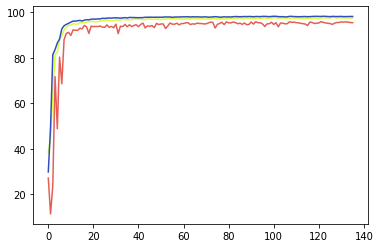

ROUND 135
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.306315


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227975
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.176503

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345500
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103505
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.433449

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.270654
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107969
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.837658

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.544722
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.4495, Accuracy: 9749/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.811928
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.657393
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.239888

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.789132
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079365
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.082942

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

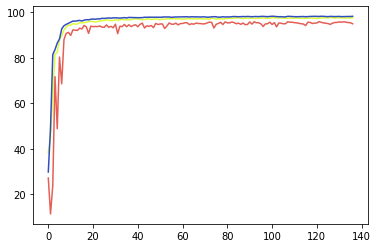

ROUND 136
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275939


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177327
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.214385

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.309139
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043912
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.331213

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.204683
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210512
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033905

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5880, Accuracy: 9749/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.829061
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.464658
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.449220

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.737680
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.347461
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.706363

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

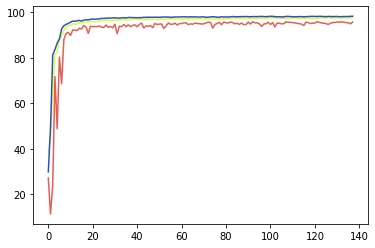

ROUND 137
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327441


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058247
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146579

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.220956
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.303775
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.345688

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357919
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031921
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.768546

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1139, Accuracy: 9751/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.758079
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309145
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.873102

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.615232
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.424201
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.297276

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

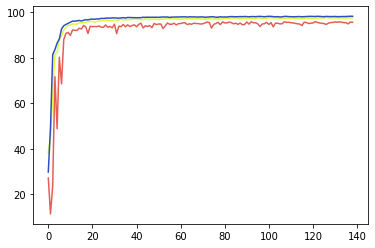

ROUND 138
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.210890


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047038
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135295

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.339627
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098946
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154275

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750160
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.328425
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282991

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.0374, Accuracy: 9742/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.847524
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.580936
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.632297

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.782743
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.535976
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.323598

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

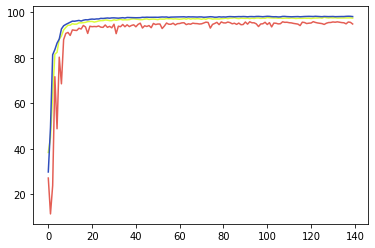

ROUND 139
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.334043


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023102
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.924625

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.401203
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142839
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221738

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244193
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278351

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.8770, Accuracy: 9751/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.861761
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.957327
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.878781

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR=

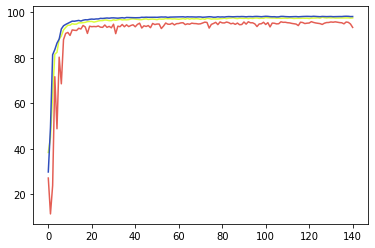

ROUND 140
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358568


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015973
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052641

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.323538
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170734
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.266193

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367034
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173215
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.499958

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.490110
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211413
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221114

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.5649, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.883285
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.639289
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.518359

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.822449
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.377069
Model

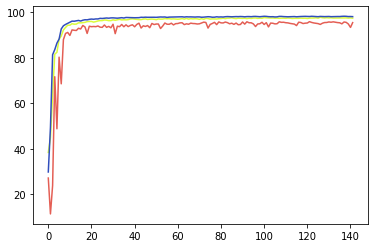

ROUND 141
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332908


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056943
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.282839

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.288978
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112945
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.227055

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.227748
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090780
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031773

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5517, Accuracy: 9751/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.660224
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.341052
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.574216

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.700178
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212688
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.514858

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

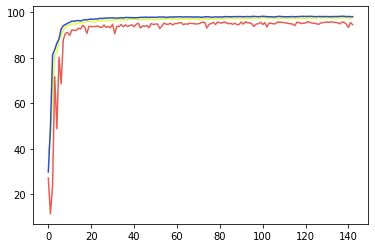

ROUND 142
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.156968


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036195
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285306

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.306249
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.443489
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161617

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.647167
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.342039
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.008436

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341439
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017726
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084940

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.6918, Accuracy: 9758/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.714415
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304185
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.042761

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.773191
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.511072
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.285403

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

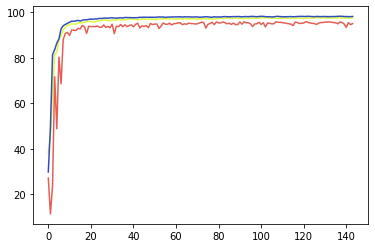

ROUND 143
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.297148


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058693
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102385

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.309037
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.370332
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056355

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.401739
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118095
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.240373

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.9601, Accuracy: 9744/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.705758
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.729651
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.267426

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.663464
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102170
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.655789

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.747348
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

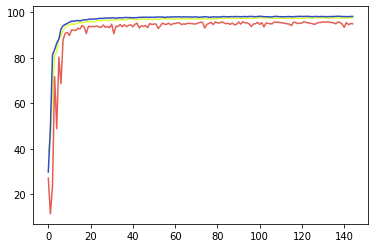

ROUND 144
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.202297


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090935
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.043386

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.225752
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064731
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.523171

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373091
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059947
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119050

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.414858
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260475
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.419623

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 4.6552, Accuracy: 9764/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.591679
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.579928
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.820592

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.622010
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.637279
Model

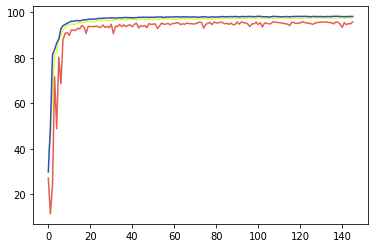

ROUND 145
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.423957


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080381
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109713

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485458
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200053
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.322884

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413255
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181243
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163380

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389508
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116227
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249027

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8084, Accuracy: 9751/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.796956
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467947
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.564698

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.835428
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.455298
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.755962

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

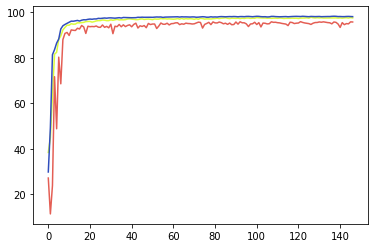

ROUND 146
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.646675


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057134
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076683

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.565302
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032368
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.294086

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.555297
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137522
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.370698

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.199812
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109600

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.8089, Accuracy: 9757/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.944064
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304310
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.681423

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.917891
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.332884
Model

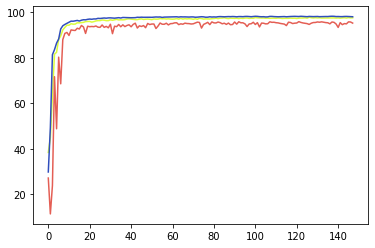

ROUND 147
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.802184


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011219
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.052954

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.665158
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113842
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231103

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.765538
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.198165
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.296002

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218847
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323093

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.2475, Accuracy: 9734/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.039128
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.449039
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.454822

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR=

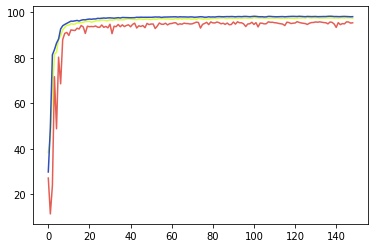

ROUND 148
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763218


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242255
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.313981

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472097
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129153
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.443168

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.381258
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050272
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.180546

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.587920
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.6914, Accuracy: 9731/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.980792
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.333489
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.504260

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.912249
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.478450
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.710973

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

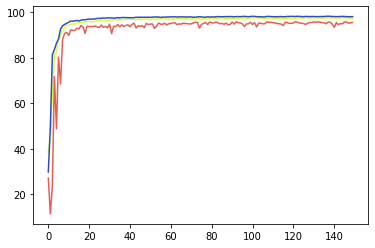

ROUND 149
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492657


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160294
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.117818

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.642973
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.301196
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.201799

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485519
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141561
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092121

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.7616, Accuracy: 9730/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.802634
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.566658
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.990224

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Poor Channel, client not taken for averaging in this round

Power

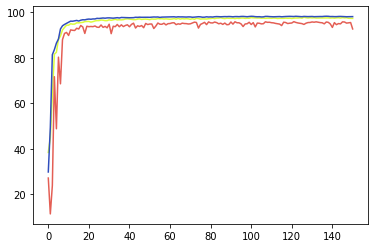

ROUND 150
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.514683


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089893
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.542531

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.431952
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024995
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075746

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.475145
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121548
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190412

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058808
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.272549

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.6291, Accuracy: 9741/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.844317
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.147415
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.347099

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.822860
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.479022
Model

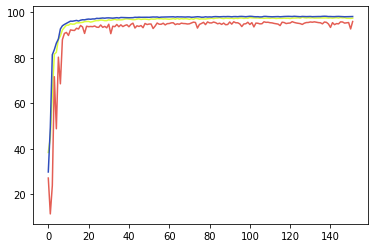

ROUND 151
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478844


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111547
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153221

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.305516
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086100
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.334767

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445670
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151101
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104335

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2650, Accuracy: 9724/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.799046
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.404510
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.290349

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.741343
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.043397
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.159091

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

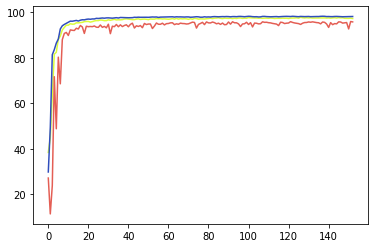

ROUND 152
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422813


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181866
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.273639

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.290472
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072291
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133854

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332322
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028838
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098256

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472517
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.0088, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.911256
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.399144
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.916135

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.805204
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.542014
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.565527

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

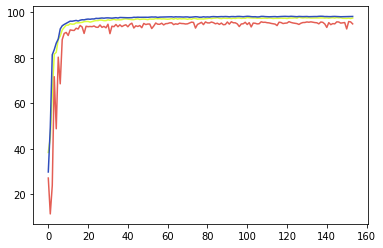

ROUND 153
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.284086


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035669
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.616680

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363382
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126872
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063831

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183138
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.223178

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.7973, Accuracy: 9760/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.897814
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247309
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.369288

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.769319
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236463
Model

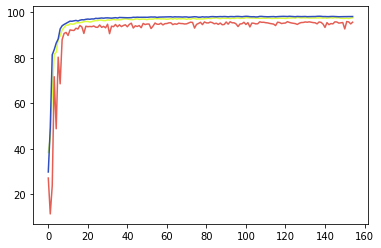

ROUND 154
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.318360


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174763
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.053557

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377858
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114452
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058586

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Model client20 Train Epoc

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2097, Accuracy: 9749/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.921725
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.146465
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.842113

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.838818
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.700890
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.788237

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

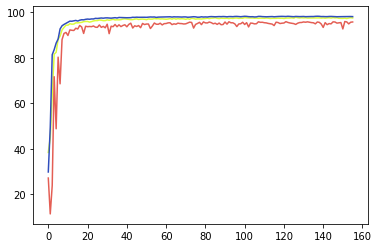

ROUND 155
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620108


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121888
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071380

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.706737
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.208785
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092116

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484464
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088032
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.349317

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.084197
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2411, Accuracy: 9731/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.000841
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.572188
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.835757

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.934333
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.601458
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.656659

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

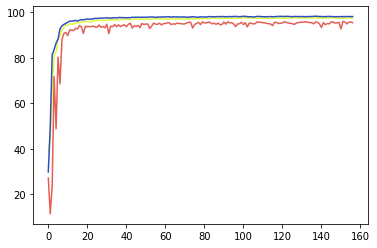

ROUND 156
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.443704


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025203
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.268124

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428598
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039459
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144627

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563918
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067240
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096940

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3102, Accuracy: 9738/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.910257
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.306628
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.429052

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.910113
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.408957
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.246954

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

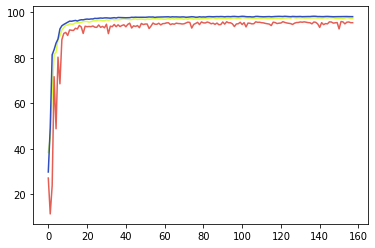

ROUND 157
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.597915


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087131
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102593

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408067
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.044470
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.491210

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.369068
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.240400
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065559

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435989
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.3741, Accuracy: 9737/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.796328
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.361186
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.772446

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.864865
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247969
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.408935

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

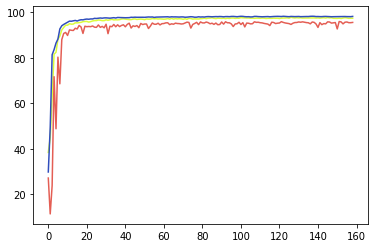

ROUND 158
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360798


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351420
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.146540

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337561
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031668
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278753

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424636
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040628
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.166859

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3090, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.761822
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.050310
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.036679

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.756051
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.497271
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.451254

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

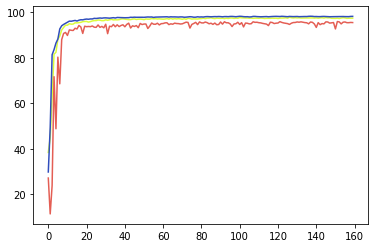

ROUND 159
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.312673


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064150
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.295703

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376781
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037555
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215319

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.348900
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.012896
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110129

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613236
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.2537, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.689579
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.412031
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.517315

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.718560
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117005
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.864489

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

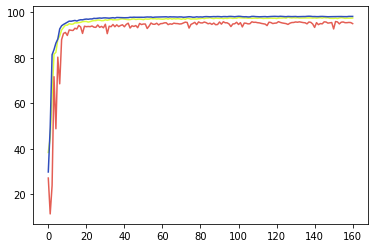

ROUND 160
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361188


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175314
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.302981

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402949
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059841
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.237166

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294160
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039481
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110069

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434867
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2224, Accuracy: 9752/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.658181
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.405211
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.485440

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.727659
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.377099
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.374807

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.856954
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

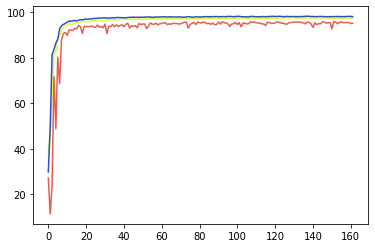

ROUND 161
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.206073


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197313
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135650

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.263902
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.128703
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022732

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337597
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197340
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.064039

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066491
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110354

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.9049, Accuracy: 9751/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.568753
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.300770
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.542943

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.783655
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.575268
Model

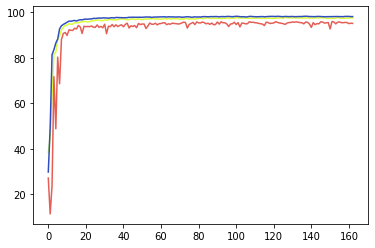

ROUND 162
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.169358


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021973
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153744

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.227424
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081032
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.065649

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.217140
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127040
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.273296

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272243
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.654042

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.4317, Accuracy: 9750/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.523661
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.285981
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.151287

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.522156
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.449643
Model

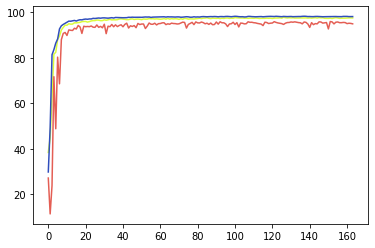

ROUND 163
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.178104


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070199
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.184626

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.465706
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.315465
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174116

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327497
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094764
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.316314

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.7559, Accuracy: 9762/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.570764
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.732632
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.381938

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.627543
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.295776
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.372601

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

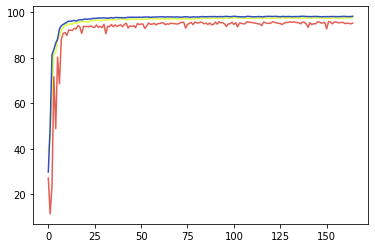

ROUND 164
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373610


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.022887
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082143

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335150
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.220021
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.215887

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461345
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139055
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104664

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441441
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113003
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.107776

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.9868, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.859679
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.230962
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.910809

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.799308
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.469057
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.441418

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

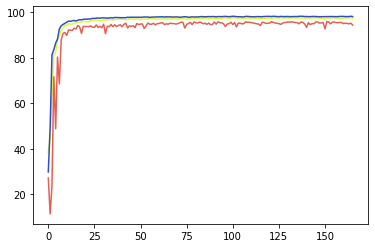

ROUND 165
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.757481


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200921
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.352945

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.669653
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065365
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289068

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.855393
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206121
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092842

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.673917
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.6578, Accuracy: 9730/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.014014
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.441086
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.557727

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.984831
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.307730
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.247525

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

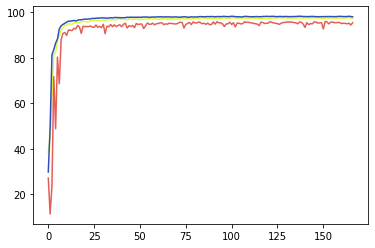

ROUND 166
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.716921


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113984
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044457

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623937
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.311587
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.331562

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456138
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072359
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.038676

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8211, Accuracy: 9734/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.898082
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.435559
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.451868

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.933593
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124008
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.557028

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

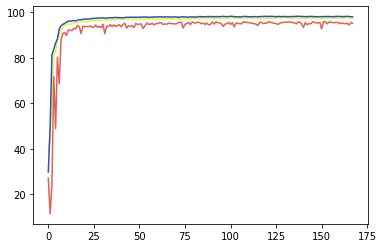

ROUND 167
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410196


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149043
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.296945

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.541461
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182157
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.071633

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.492952
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141491
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.241507

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496369
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281485
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123621

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.3519, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.818430
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.369040
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.839454

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.793745
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.397212
Model

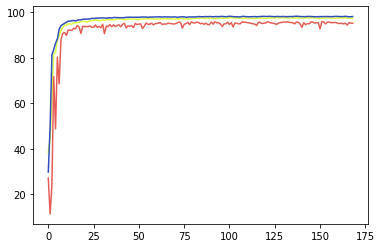

ROUND 168
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366933


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033771
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050971

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388256
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066728
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.465937

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676427
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236925
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026025

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138301
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.062951

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.4026, Accuracy: 9735/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.914728
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.217775
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.431464

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.918222
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.869593
Model

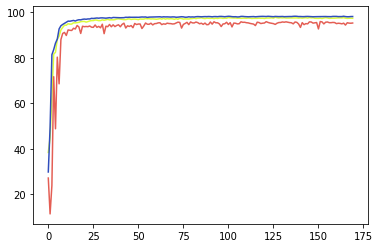

ROUND 169
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.194467


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017619
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.163891

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427529
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.204921
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.217976

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.337331
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107434
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.004698

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439779
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1821, Accuracy: 9737/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.672370
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.612340
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.398408

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.713334
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400227
Model client13 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.224663

Power Allocated= 6.836233321466889
CSI= 0.400704

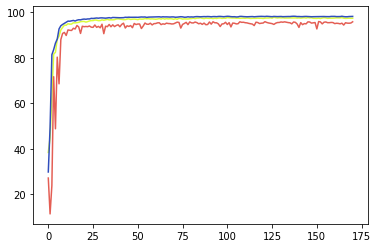

ROUND 170
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363124


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153270
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.410463

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.252246
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030244
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.318104

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385715
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098294
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252674

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.269651
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8022, Accuracy: 9741/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.601136
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.296659
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.659203

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.696070
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.245067
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.890214

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

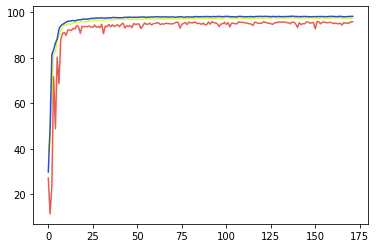

ROUND 171
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256695


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031621
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.338382

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.296168
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018086
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006909

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060099
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.491952

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 1.9925, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.555208
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.656005
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.479565

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.754133
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.439502
Model

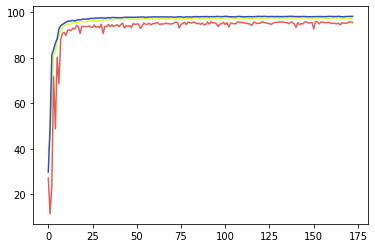

ROUND 172
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.370200


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051223
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.227552

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.267459
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145563
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.488166

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.233780
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071289
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009448

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.377744
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176270
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097167

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.2102, Accuracy: 9757/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.635355
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.408675
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.802157

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.617967
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323343
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.810700

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

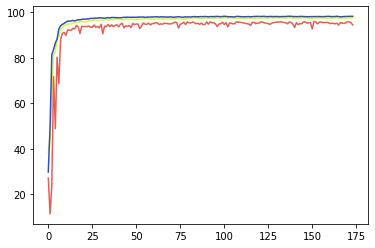

ROUND 173
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.130414


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025374
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.129411

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.385635
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032778
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.722703

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364112
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115650
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.576241

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472389
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060011
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068362

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.3398, Accuracy: 9752/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.618532
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241542
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.981642

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.727219
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138808
Model

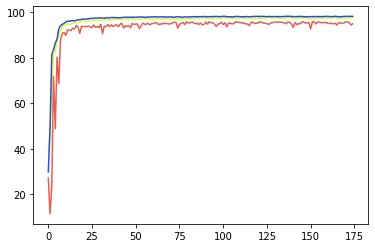

ROUND 174
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.220717


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021431
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255398

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.326264
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084817
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317011

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.362155
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068620
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009216

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.221349
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.5086, Accuracy: 9748/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.840544
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.025831
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.557108

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.626365
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.237319
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.548311

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

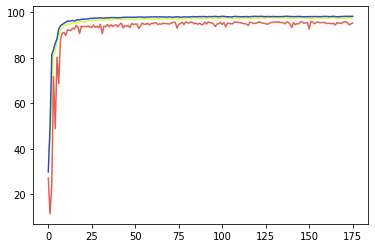

ROUND 175
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.211182


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.401454
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.127128

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.240343
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039469
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.742817

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.185889
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117551
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.005045

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.261269
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.1573, Accuracy: 9756/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.613575
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181194
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.567790

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.676045
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.356588
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.889797

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

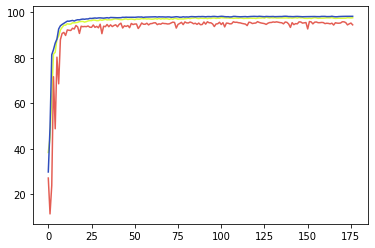

ROUND 176
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.106591


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.020126
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.454043

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.190758
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265108
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.506711

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.159102
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226818
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096358

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.7603, Accuracy: 9757/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.491693
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.628097
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.493201

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.436437
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.349472
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077987

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.530978
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

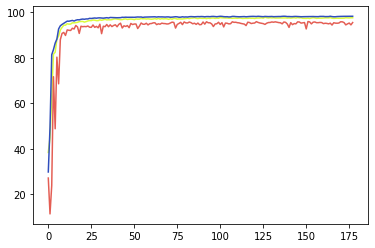

ROUND 177
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.333638


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109791
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218434

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.285581
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286603
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.541086

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402152
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100468
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.055798

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.4436, Accuracy: 9755/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.581601
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.215432
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.753602

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.680974
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.905997
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.978349

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

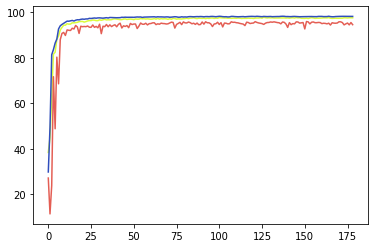

ROUND 178
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.266450


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.057556
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143183

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.215749
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.267720
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.135311

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.270396
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158322
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.122110

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8623, Accuracy: 9764/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.668118
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294433
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.300117

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.016936
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.377217
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.937068

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

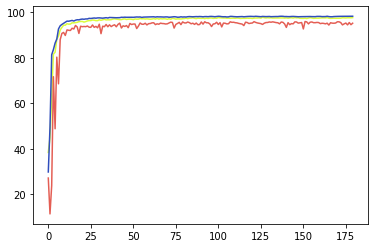

ROUND 179
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363128


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058107
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.060807

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.338959
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060531
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132374

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.625640
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170119
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032381

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.9936, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.856237
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169683
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.680419

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.883584
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.503826
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.774956

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

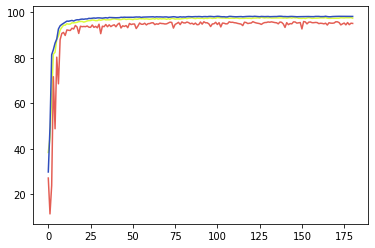

ROUND 180
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.327148


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115977
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152338

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.283898
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030081
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068071

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461178
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050426
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335223

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.1832, Accuracy: 9751/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.858978
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.461168
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.116009

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.840759
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.587898
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.523346

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

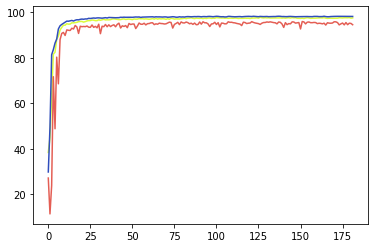

ROUND 181
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505102


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021535
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.113204

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734399
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.265140
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116730

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.698537
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077547
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073289

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.579654
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124550
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.067230

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.0760, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.046113
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.436063
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.071685

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.905094
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.702318
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.891130

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

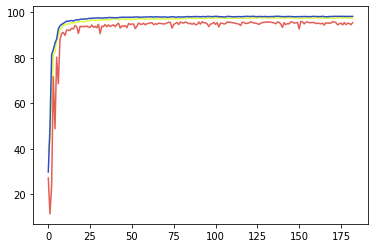

ROUND 182
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.234532


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052309
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045920

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.310464
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170741
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112342

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 0.9687, Accuracy: 9737/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.640371
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.171743
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.978112

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.874323
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.533942
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.467322

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.759241
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

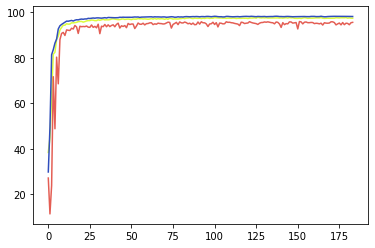

ROUND 183
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294688


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030572
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.246660

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610631
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118591
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026758

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.259918
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209367
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323357

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.135240
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.333719

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.7170, Accuracy: 9741/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.887099
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.549960
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.127210

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.784588
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139246
Model

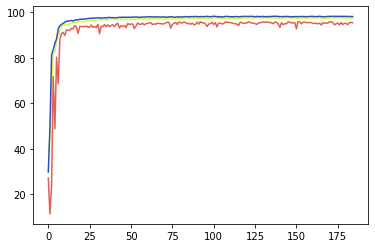

ROUND 184
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.368100


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035422
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.258692

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564323
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.193415
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.255629

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.247401
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099374
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.136066

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.391542
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.126945
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119032

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.2467, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.807437
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.396650
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.353733

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.854820
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.458797
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.888996

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

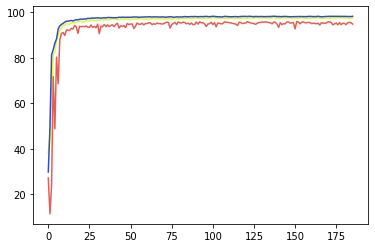

ROUND 185
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219559


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036737
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.044855

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325169
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136919
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.241914

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.202668
Model client18 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169879
Model client18 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.710229

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.2413, Accuracy: 9741/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.744479
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248120
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.344229

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.809939
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334142
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.692695

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

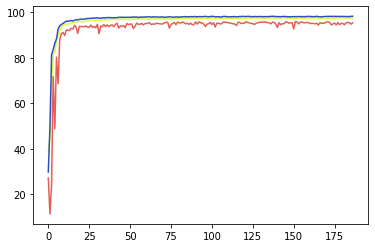

ROUND 186
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621321


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224242
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.099730

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.544807
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055916
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076776

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.501896
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226085
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115014

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.3301, Accuracy: 9743/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.851115
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.259090
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.667448

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.814231
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170001
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.136709

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.867190
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

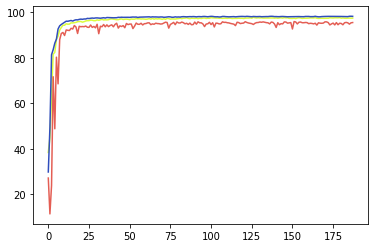

ROUND 187
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386587


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064540
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449567

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.370763
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151140
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.090350

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.432551
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.210549
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125925

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353488
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071946
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140062

Power Allocated= 1.8064022749515454
CSI= 0.2826

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 4.1832, Accuracy: 9743/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.764437
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.634521
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 3.062470

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.753477
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.304592
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.335607

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

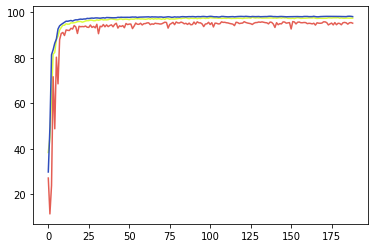

ROUND 188
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.440263


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002844
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032020

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.430033
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069060
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.263818

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.660461
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.132830
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.590658

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.8886, Accuracy: 9730/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.890662
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362836
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.279060

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.980095
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.371156
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.183806

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

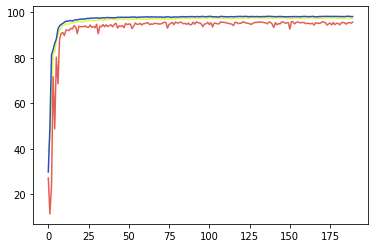

ROUND 189
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.228284


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070743
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190396

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335834
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121001
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046791

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386202
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185958
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.857354

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.7315, Accuracy: 9740/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.738171
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.738010
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.116565

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.874769
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.820993
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.602405

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

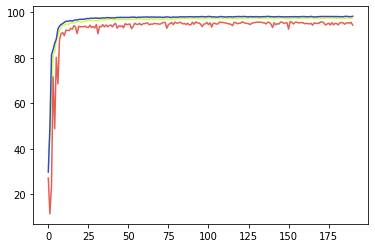

ROUND 190
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.276803


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079907
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029798

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.278971
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109268
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189111

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.316377
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115222
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.211701

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3434, Accuracy: 9742/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.849314
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.220686
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.990089

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.802909
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.704355
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.681551

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

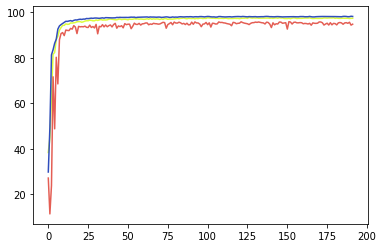

ROUND 191
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446253


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166504
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104262

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.331073
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055315
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.092186

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615971
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155948
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.199012

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power All

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.7724, Accuracy: 9735/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.863099
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.922530
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.469418

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.928447
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.599523
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.321798

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

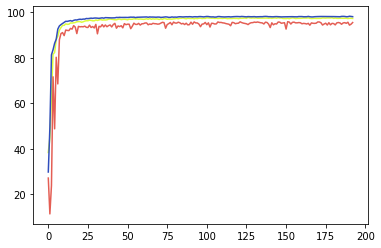

ROUND 192
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455207


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033145
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.048587

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.508012
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061951
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.299777

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516189
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067825
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110691

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.712013
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 2.0851, Accuracy: 9719/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.957649
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.784399
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.910879

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.943425
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145429
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.667991

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Model client13 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.058426
Model client13 Train Epoch: 2 [0/1216 (0%)]	Loss:

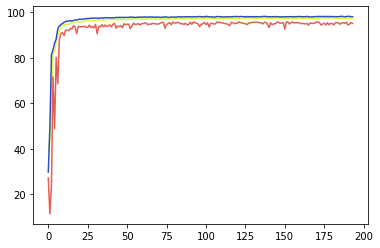

ROUND 193
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Model client2 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.648310


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client2 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.251782
Model client2 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.383228

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415684
Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099042
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.763588

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.693399
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083159
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153200

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562308
Model clie

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169769
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.254557

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.8457, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.041959
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.936671
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.884940

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.890769
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.351704
Model

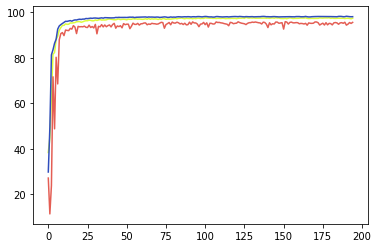

ROUND 194
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.304626


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070805
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141909

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.591168
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048130
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285252

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.419935
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.238302
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.288747

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.720067
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 4.9827, Accuracy: 9746/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.765266
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.557645
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.746544

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.795763
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.622465
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.455383

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

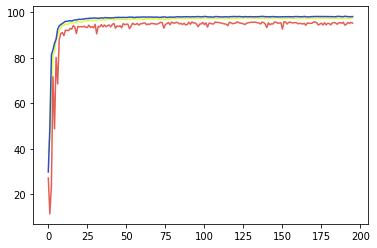

ROUND 195
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422271


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.241827
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153716

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Model client12 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275581
Model client12 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077495
Model client12 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.429257

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.339393
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.064013
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.183773

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043499
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110473

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 3.6028, Accuracy: 9764/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.602279
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.711313
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.753857

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.848384
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.530569
Model

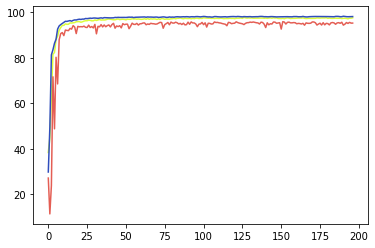

ROUND 196
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.161731


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024766
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020094

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.284813
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015545
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097561

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321958
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079618
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097600

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Model client18 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.219399
Model c

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 3.2068, Accuracy: 9743/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.649954
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.540644
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.696957

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.40070413053308795
SNR= 17.966154439101516
Client: client19
Model client19 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.651538
Model 

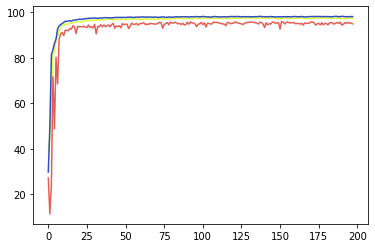

ROUND 197
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.399173


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034217
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.157074

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.280321
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131826
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480707

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.239152025136011
CSI= 0.4750566409538538
SNR= 6.008390406083533
Client: client20
Poor Channel, client not 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide



Test set: Average loss for Cluster1 model: 1.3782, Accuracy: 9739/10000 (97%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.758893
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.876479
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.726928

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Model client10 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.772835
Model client10 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.264781
Model client10 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.645011

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR= 6.366326824297223
Client: client13
Poor Channel, client not taken for averaging in this round

Power Allocated= 6.836233321466889
CSI= 0.400704

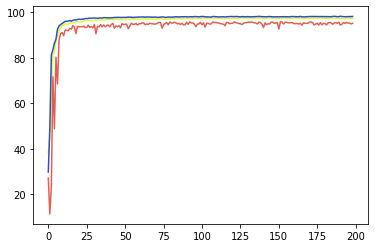

ROUND 198
0.18711999999999385
Power Allocated= 3.491377581227553
CSI= 0.5397275674326653
SNR= 5.538019752395738
Client: client2
Poor Channel, client not taken for averaging in this round

Power Allocated= 3.5182618333465396
CSI= 0.5476744174286939
SNR= 23.26199515085822
Client: client8
Model client8 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.258484


/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/test/anaconda3/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:156: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you a

Model client8 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028680
Model client8 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070343

Power Allocated= 3.337171916637757
CSI= 0.49825802614220305
SNR= 7.5267786435477815
Client: client12
Poor Channel, client not taken for averaging in this round

Power Allocated= 1.411272492114958
CSI= 0.25426583827125715
SNR= 20.593704210594947
Client: client14
Model client14 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335032
Model client14 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055638
Model client14 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.386689

Power Allocated= 4.196180496999148
CSI= 0.8710925260927321
SNR= 18.187199405276026
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341873
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036419
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.362222

Power Allocated= 1.8064022749515454
CSI= 0.2826645853780527
SNR= 9.69445130593417
Client: client18
Poor Channel, client not taken for averaging in this round

Power 

/home/test/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in true_divide


Model client48 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108461
Model client48 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.123196

Power Allocated= 0
CSI= 0.178717937014652
SNR= 28.826661974222592
Client: client49
Poor Channel, client not taken for averaging in this round


Test set: Average loss for Cluster1 model: 2.0989, Accuracy: 9750/10000 (98%)

0.10716000000001247
Power Allocated= 0
CSI= 0.0654438676663216
SNR= 24.864674124512156
Client: client1
Poor Channel, client not taken for averaging in this round

Power Allocated= 7.96850080203111
CSI= 0.7334930487311584
SNR= 25.34758668697715
Client: client6
Model client6 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.834777
Model client6 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.535683
Model client6 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.330154

Power Allocated= 7.604514116908847
CSI= 0.5789294721315987
SNR= 22.576322114113374
Client: client10
Poor Channel, client not taken for averaging in this round

Power Allocated= 8.176257077681115
CSI= 0.8653639422630494
SNR=

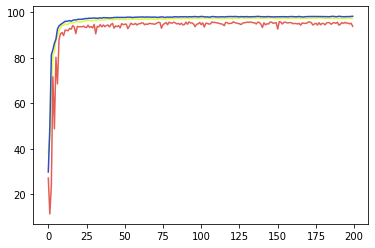

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]   
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[38.37, 27.11, 29.78], [44.85, 11.35, 49.36], [63.75, 23.82, 81.34], [81.56, 71.66, 83.57], [82.4, 48.78, 86.43], [88.11, 80.26, 88.21], [89.54, 68.54, 92.66], [92.2, 87.96, 94.05], [93.33, 90.69, 94.64], [94.31, 91.12, 95.12], [94.3, 89.79, 95.65], [94.95, 92.23, 96.09], [94.75, 92.07, 96.05], [94.8, 91.98, 96.21], [95.35, 92.96, 96.4], [95.32, 92.64, 96.13], [95.44, 94.18, 96.5], [95.55, 93.53, 96.7], [95.87, 90.68, 96.66], [95.94, 93.85, 96.88], [95.96, 93.65, 97.0], [95.66, 93.74, 96.91], [95.88, 93.66, 97.06], [96.17, 93.96, 97.05], [96.32, 93.44, 97.32], [96.33, 93.36, 97.26], [96.59, 94.4, 97.36], [96.51, 93.36, 97.47], [96.3, 93.79, 97.38], [96.32, 93.16, 97.51], [96.66, 94.73, 97.53], [96.46, 90.58, 97.45], [96.69, 93.87, 97.39], [96.88, 93.65, 97.52], [96.62, 94.62, 97.61], [96.69, 93.62, 97.46], [96.65, 94.47, 97.7], [96.74, 93.69, 97.67], [97.02, 94.19, 97.68], [97.1, 94.48, 97.59], [96.99, 93.61, 97.58], [96.84, 94.66, 97.62], [96.75, 95.19, 97.62], [96.76, 93.06, 97.79],